# Temporal Fusion Transformer (TFT) Model - Traffic & Electricity Benchmark Tests

- **Master Thesis**: *'Time Series Forecasting using Transformers'*
- **Author**: Andrés Carrillo López
- **Thesis Tutor**: Pablo Martínez Olmos

**Goal of this notebook**: Understand how the aggregated '**Traffic**' and '**Electricity**' popular benchmark datasets are used in the TFT model (i.e. identify predictors, target variables, how scaling is done, how is data feeded into model...). Once the datasets have been retrieved, aggregated and formatted as in Google's experiments (after checking Google-Researc/tft repo), instead of using their implemented TFT, the datasets will be then processed (individually) for the Pytorch-Forecasting library 'TimeSeriesDataset' format and tested using both a simple naive forecast baseline as well as the TemporalFusionTransformer model implemented in the *Pytorch-Forecasting* library.

**Note**: most results and plots analysis and comments will be done in the thesis document itself. This notebook is for implementation / tests code mainly, although is fully documented to explain steps followed as well as consulted documentation.

<figure>
<center>
<img src='https://images.deepai.org/converted-papers/1912.09363/TemporalFusion.png' width="600" height="350"/>
<figcaption>Temporal Fusion Transformer architecture (Bryan Lim et al, 2020)</figcaption></center>
</figure>



---

For each **dataset** (Traffic, and Electricity), and for each **forecast scenario** (1 day and 1 week forecast horizons), the following **workflow** is followed (as of notebook structure):


1. Setup: installation of required libraries, setting up data environment.
2. Loading aggregated data.
3. Time-Series Dataset Object creation (Pytorch-forecastinc compatible)
4. Model declaration and training (fitting).
5. Model Evaluation, Interpretation and Forecast visualizations.

---

## Intro / Context

As the [repository](https://github.com/google-research/google-research/tree/master/tft) from Google Research paper titled "[Temporal Fusion Transformersfor Interpretable Multi-horizon Time Series Forecasting](https://arxiv.org/pdf/1912.09363v3.pdf)" has been used for data extraction and aggregation, the following relevant excerpts from the mentioned papers have been issued:

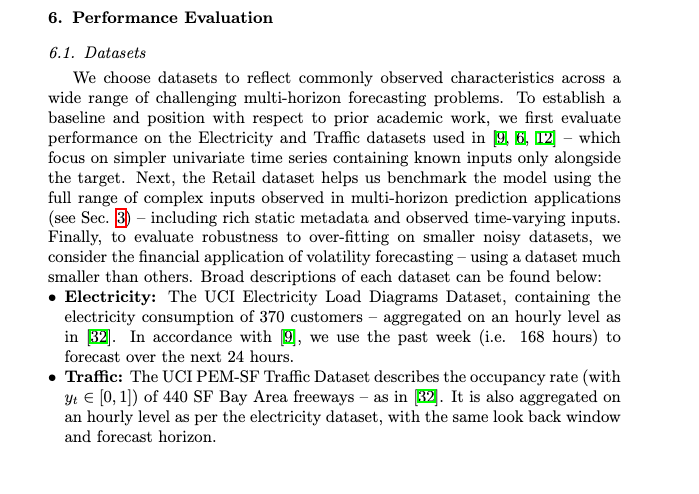

These datasets are a popular common benchmark among the different Transformer and other SotA models in the literature, and hence used in this tests.

- Traffic Dataset: https://archive.ics.uci.edu/ml/datasets/PEMS-SF

- Electricity Dataset: https://archive.ics.uci.edu/ml/datasets/ElectricityLoadDiagrams20112014

As an important note: even though the paper authors only evaluate the performance of 1-day forecasts; in this thesis project **I will also consider 1-week forecasts**, in order to evaluate long-term forecast performance based on the prior week.

## Setup

*Note: this colab environment is being run on a GPU environment.

### External libraries

Installing Libraries not included in Colab:

In [4]:
!pip install pytorch-lightning==1.1.8 -q
!pip install pytorch-forecasting -q
!pip install torchtext==0.6.0 -q

ERROR: pytorch-forecasting 0.8.5 has requirement pytorch-lightning<2.0.0,>=1.2.4, but you'll have pytorch-lightning 1.1.8 which is incompatible.


In [5]:
# Generic libraries
import pandas as pd
import seaborn as sns
import numpy as np
# Pytorch / Pytorch lightning dependencies
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch
# Pytorch Forecasting library
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import TorchNormalizer, GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, MAE,RMSE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [7]:
# Note: my Google Drive has been synced with this colab notebook previously
%cd "drive/MyDrive/Máster Big Data (2020-2021)/TFM/Code Notebooks"

/content/drive/MyDrive/Máster Big Data (2020-2021)/TFM/Code Notebooks


In [ ]:
# In the 'data' folder both the electricity and traffic aggregated datasets were previously stored
!ls data/

 aggr_data   electr  'Raw data'   traffic


### Cloning Google-Research Repo

Note: as next cell already executed on my drive folder, not needed to execute again.

In [ ]:
# For cloning a specific subfolder, better use subversion (git cannot)
#!apt install -q subversion
#!svn export https://github.com/google-research/google-research/trunk/tft -q

In [ ]:
# check that the "tft" folder has been added to the tfm drive folder
!ls | grep tft

tft


In [ ]:
# I need to import the files as a library from my foldrs
#!touch tft/__init__.py

In [8]:
%cd tft

/content/drive/MyDrive/Máster Big Data (2020-2021)/TFM/Code Notebooks/tft


In [ ]:
# Checking the Google's repo
!ls

data_formatters      lightning_logs		   traffic
electr		     __pycache__		   traffic_logs
electricity_logs     README.md			   traffic_logs_1week_1
electr_logs_1week_1  requirements.txt		   traffic_logs2
electr_logs_1week_2  run.sh			   traffic_logs3
expt_settings	     script_download_data.py	   traffic_logs4
__init__.py	     script_hyperparam_opt.py
libs		     script_train_fixed_params.py


In [ ]:
# Making sure all needed libraries of Google lib and exact versions are matched
!pip install -r requirements.txt --q

     |████████████████████████████████| 81kB 5.2MB/s 




---


## Traffic Dataset

**Note*: Data retrieval, aggregation and exploration done in the other notebook.

### Loading aggregated data

First we load the aggregated data (already processed in the other notebook)

In [7]:
traffic_df_hourly = pd.read_csv("../data/traffic/hourly_data.csv", index_col=0)
traffic_df_hourly

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



values  ...  categorical_time_on_day
0         0.019333  ...                        1
1         0.020200  ...                        2
2         0.022450  ...                        3
3         0.029283  ...                        4
4         0.055483  ...                        5
...            ...  ...                      ...
10160942  0.041400  ...                       19
10160943  0.037300  ...                       20
10160944  0.035400  ...                       21
10160945  0.029750  ...                       22
10160946  0.022700  ...                       23

[3997413 rows x 11 columns]

Note: it could be useful to perform normalization on target variable on the **entire** dataset, not grouping by category/sensor whatsoever (as opposite as for the electricity case, where some papers perform scaling by group).

For more details about processing / scaling done: [here](https://github.com/google-research/google-research/blob/1be2672e6997db8113a6cff20a26ab870fa6f442/tft/data_formatters/volatility.py#L87) (scales real attributes on one side, then target scaling, and then categorical scaling).

Recall from Google TFT paper usage of data:
> - The UCI PEM-SF Traffic Dataset describes the occupancy rate (with $y_t\in [0,1]$) of 440 SF Bay Area freeways – as in [32].  It is also aggregated on an hourly level as per the electricity dataset, with the same look back window (1 week = 7*24 = 168 hours) and forecast horizon (24hrs).

We can check how Google-Research experiment formatted their data:

```
# From tft/data_formatters/traffic.py:

 _column_definition = [
      ('id', DataTypes.REAL_VALUED, InputTypes.ID),
      ('hours_from_start', DataTypes.REAL_VALUED, InputTypes.TIME),
      ('values', DataTypes.REAL_VALUED, InputTypes.TARGET),
      ('time_on_day', DataTypes.REAL_VALUED, InputTypes.KNOWN_INPUT),
      ('day_of_week', DataTypes.REAL_VALUED, InputTypes.KNOWN_INPUT),
      ('hours_from_start', DataTypes.REAL_VALUED, InputTypes.KNOWN_INPUT),
      ('categorical_id', DataTypes.CATEGORICAL, InputTypes.STATIC_INPUT),
  ]

# from tft/libs/tft_model.py#L708 (function "_batch_data()"):

   id_col = self._get_single_col_by_type(InputTypes.ID)
    time_col = self._get_single_col_by_type(InputTypes.TIME)
    target_col = self._get_single_col_by_type(InputTypes.TARGET)
    input_cols = [
        tup[0]
        for tup in self.column_definition
        if tup[2] not in {InputTypes.ID, InputTypes.TIME}
    ]
```



In other words, we have that:

- **id column**: the ***id*** columns, which is referring to ... 
- **time column** is the time index, so: ***hours_from_start***
- **target column** is the value we want to predict (the *y*). In this case, the occupancy rate in column ***values***.
- **input columns** are the rest of set of predictors used in the model, known inputs: 
    - ***time_of_day, day_of_week , hours_from_start, categorical_id*** (static, categorical). 


### TimeSeriesDataset Creation (Pytorch-Forecasting Compatibility)

Data preprocessing is crucial for using custom datasets for the transformer models, as they need to be specifically adapted for the models architectures. On that hand, the following documentation has been checked for understanding its inner working:


- Check [Pytorch-Forecasting Docs on Dataset Building](https://pytorch-forecasting.readthedocs.io/en/latest/tutorials/building.html#Passing-data-to-a-model)
- Class Documentation of [TimeSeriesDataset](https://pytorch-forecasting.readthedocs.io/en/latest/api/pytorch_forecasting.data.timeseries.TimeSeriesDataSet.html#pytorch_forecasting.data.timeseries.TimeSeriesDataSet)
- Check [Stallion Dataset Declaration example](https://pytorch-forecasting.readthedocs.io/en/latest/tutorials/stallion.html)
- Review [astype()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.astype.html) type conversion Pandas function for setting correct datatypes expected.

> [(From docs)](https://pytorch-forecasting.readthedocs.io/en/latest/tutorials/building.html#Passing-data-to-a-model): The data has to be in a specific format to be used by the TimeSeriesDataSet. It should be in a pandas DataFrame and AT LEAST MUST HAVE a **categorical column to identify each series** and a **integer column to specify the time of the record**.

That is, we need to explicitly denote the 'time' column, as well as the 'id' column (the one which differentiated the stations (i.e. differnet series) we had in our dataset)

In [ ]:
# Checking data grouped by id
traffic_df_hourly.groupby(by='categorical_id').describe()

values                                ... categorical_time_on_day                  
                 count      mean       std       min  ...                     25%   50%   75%   max
categorical_id                                        ...                                          
400000          4151.0  0.049574  0.026267  0.005383  ...                     6.0  12.0  17.5  23.0
400001          4151.0  0.042554  0.040099  0.002950  ...                     6.0  12.0  17.5  23.0
400009          4151.0  0.067712  0.048093  0.006250  ...                     6.0  12.0  17.5  23.0
400010          4151.0  0.057218  0.042320  0.000000  ...                     6.0  12.0  17.5  23.0
400015          4151.0  0.030989  0.025899  0.002050  ...                     6.0  12.0  17.5  23.0
...                ...       ...       ...       ...  ...                     ...   ...   ...   ...
402086          4151.0  0.052826  0.037338  0.002650  ...                     6.0  12.0  17.5  23.0
402087          4151.0  0.059557  0.043865  0.003000  ...                     6.0  12.0  17.5  23.0
402088          4151.0  0.061144  0.049728  0.001383  ...                     6.0  12.0  17.5  23.0
402089          4151.0  0.059703  0.045645  0.002250  ...                     6.0  12.0  17.5  23.0
402090          4151.0  0.064364  0.043376  0.002600  ...                     6.0  12.0  17.5  23.0

[963 rows x 80 columns]

Some extra variable understanding checks...

In [ ]:
total_t = 4141/24 #total n days per id
total_t 

172.54166666666666

In [ ]:
traffic_df_hourly.groupby(by='categorical_id').describe().shape[0] # rows = total number of different sensors

963

In total there are 963 category_ids (sensor ids). Each of them is a individual target (sensor) time series.

#### Setting up variable datatypes

First, some attributes need specific formatting (datatype conversion,...), as recommended on the library documentation.

In [8]:
#id starting on 0, by substracting 400000 (i.e. .min())
traffic_df_hourly["categorical_id"] = (traffic_df_hourly["categorical_id"] - traffic_df_hourly["categorical_id"].min()).astype(int)
traffic_df_hourly["id"] = (traffic_df_hourly["id"] - traffic_df_hourly["id"].min()).astype(int)

# renaming values column
traffic_df_hourly["y_values"] = traffic_df_hourly["values"] 

# Converting all features to desired datatype (categorical, int, ...)
traffic_df_hourly["day_of_week"] = traffic_df_hourly["day_of_week"].astype(str).astype("category")
traffic_df_hourly["hours_from_start"] = traffic_df_hourly["hours_from_start"].astype(int)
traffic_df_hourly["id"] = traffic_df_hourly["id"].astype("category")
traffic_df_hourly["categorical_id"] = traffic_df_hourly["categorical_id"].astype(str).astype("category")
traffic_df_hourly["time_on_day"] = traffic_df_hourly["time_on_day"].astype(int)

### 1-day Traffic rate occupation Forecast Scenario

#### Declaring TimeSeriesDataset Object

Recall:


    id column: the id columns, which is referring to ...
    time column is the time index, so: hours_from_start
    target column is the value we want to predict (the y). In this case, the occupancy rate in column values.
    input columns are the rest of set of predictors used in the model, known inputs:
        time_of_day, day_of_week , hours_from_start, categorical_id (static, categorical).


         fixed_params = {
        'total_time_steps': 8 * 24,
        'num_encoder_steps': 7 * 24,
        'num_epochs': 100,
        'early_stopping_patience': 5,
        'multiprocessing_workers': 5
    }

Here, **parameters are adjusted based on author's recommended settings** for this dataset (found in paper).

In [9]:
max_prediction_length = 24 # predict max 1 day ahead
max_encoder_length = 7*24 #using last 7 days

# Sets limit for training data (last index prior to max prediction sequence)
training_cutoff = traffic_df_hourly["hours_from_start"].max() - max_prediction_length

training = TimeSeriesDataSet(
    traffic_df_hourly[lambda x: x.hours_from_start <= training_cutoff],
    time_idx="hours_from_start", # variable that contains the time index
    target="y_values", # target variable to predict
    group_ids=["categorical_id"], # Groups used for later normalizing
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1, # at least we predict 1 time index
    max_prediction_length=max_prediction_length,
    static_categoricals=["categorical_id"], # they do not change along a same time index
    #static_reals=[], # same as before but real values
    time_varying_known_categoricals=["day_of_week"], # cats that change for same time idx
    #variable_groups={},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["time_on_day", "hours_from_start"],
    #time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "y_values"
    ], # values that are not supposed to be known in the future
    target_normalizer=TorchNormalizer(),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True, # to add the center and scale of the unnormalized timeseries as features  TODO change to false
    add_encoder_length=True, # adds decoder length to list of static real variables. 
)

In [10]:
# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, traffic_df_hourly, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

#### Baseline (Naive forecast) Test

We can quickly check the generated time series dataset and dataloaders by executing a simple baseline forecast (naive forecast)

In [ ]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

0.04220527037978172

#### Temporal Fusion Transformer Test

From TFT GoogleResearch experiment, they used the following parameters:


```
    fixed_params = {
        'total_time_steps': 8 * 24,
        'num_encoder_steps': 7 * 24,
        'num_epochs': 100,
        'early_stopping_patience': 5,
        'multiprocessing_workers': 5
    }
    model_params = {
        'dropout_rate': 0.3,
        'hidden_layer_size': 320,
        'learning_rate': 0.001,
        'minibatch_size': 128,
        'max_gradient_norm': 100.,
        'num_heads': 4,
        'stack_size': 1
    }
```





In [ ]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=1,
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.01,
    hidden_size=320,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=4,
    dropout=0.3,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=128,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=5,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 42
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning:

You have set progress_bar_refresh_rate < 20 on Google Colab. This may crash. Consider using progress_bar_refresh_rate >= 20 in Trainer.

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Number of parameters in network: 6350.2k


We can use Pytorch Lightning "learning rate tuner" to find best suitable initial learning rate for the model as follows:


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 72.3 K
3  | prescalers                         | ModuleDict                      | 1.8 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 355 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 475 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 356 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 411 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 411 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 411 

Restored states from the checkpoint file at /content/drive/My Drive/Máster Big Data (2020-2021)/TFM/Code Notebooks/tft/lr_find_temp_model.ckpt


suggested learning rate: 0.0019498445997580445


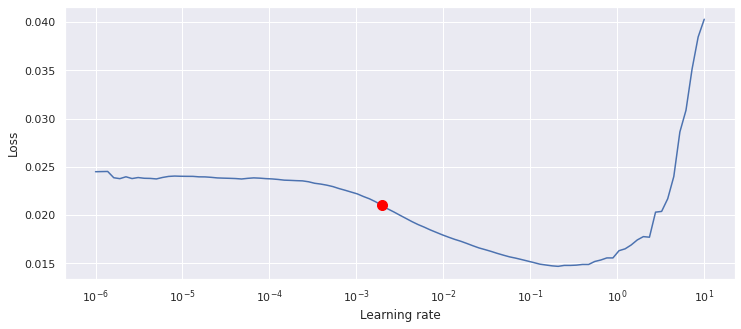

In [ ]:
res = trainer.tuner.lr_find(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [ ]:
# to solve issue on training
import tensorflow as tf 
import tensorboard as tb 
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

Tensorboard is of good use to check 'live' the model training execution:

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
%tensorboard --logdir traffic_logs4

In [ ]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("traffic_logs4")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=25,
    gpus=1, #1 for gpu
    weights_summary="top", #for printing a summary of the model parameters
    gradient_clip_val=0.1,
    limit_train_batches=320,  # training over batches of 320
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.1,
    hidden_size=320,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=4,
    dropout=0.3,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=64,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=5,
)

print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning:

You have set progress_bar_refresh_rate < 20 on Google Colab. This may crash. Consider using progress_bar_refresh_rate >= 20 in Trainer.

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Number of parameters in network: 5689.8k


In [ ]:
# fit network
trainer.fit(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)

Once the trainer has found best model parameters, we will retrieve it and also keep a look on the path where it has been stored (for later usage without having to retrain the model). Hence, **NO NEED TO EXECUTE PREVIOUS CELL if model was already trained, only load it from below cell:**

In [ ]:
!ls ../../trained_models/

arima_model_electr.pkl       tft_model_electr_1week.ckpt
arima_model_traffic.pkl      tft_model_traffic_1day.ckpt
tft_model_electr_1day.ckpt   tft_model_traffic_1week.ckpt


In [ ]:
# Loading best achieved model during training (from checkpoint)
#best_model_path = trainer.checkpoint_callback.best_model_path #pytorch lightning saved the best
best_model_path = "../../trained_models/tft_model_traffic_1day.ckpt"
print(best_model_path)
# /Code Notebooks/tft/traffic_logs4/default/version_4/checkpoints/epoch=23-step=7679.ckpt
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

../../trained_models/tft_model_traffic_1day.ckpt


In [ ]:
# Model evaluation (MAE and RMSE)
score = {"MAE" :  best_tft.logging_metrics[1], 
         "RMSE" : best_tft.logging_metrics[2]}
         
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)

tft_MAE = score["MAE"](predictions, actuals)
tft_RMSE = score["RMSE"](predictions, actuals)

print(f"TFT Model MAE (1 day forecast): {tft_MAE:.7f}")
print(f"TFT Model RMSE (1 day forecast): {tft_RMSE:.7f}")

TFT Model MAE (1 day forecast): 0.0098611
TFT Model RMSE (1 day forecast): 0.0357859


We can particularize the predictions to those of the target road sensor "0" (the one analyzed in the clasical forecasting models) as follows:

In [ ]:
raw_predictions, x, indx = best_tft.predict(val_dataloader, return_index=True, mode="raw", return_x=True)

sns.set(rc={'figure.figsize':(12,5)}) 

# Index 3 corresponds road sensor 0 analyzed in the classical forecasting notebook
# we plot a validation batch, and the average losses (title)
best_tft.plot_prediction(x, raw_predictions, idx=3, add_loss_to_title=MAE());
best_tft.plot_prediction(x, raw_predictions, idx=3, add_loss_to_title=RMSE());

#### Interpreting the TFT model and predictions

Now, we can visualize the predictions for the rest of the road sensors, as well as gaining some insights about model interpretability and attention mechanism:

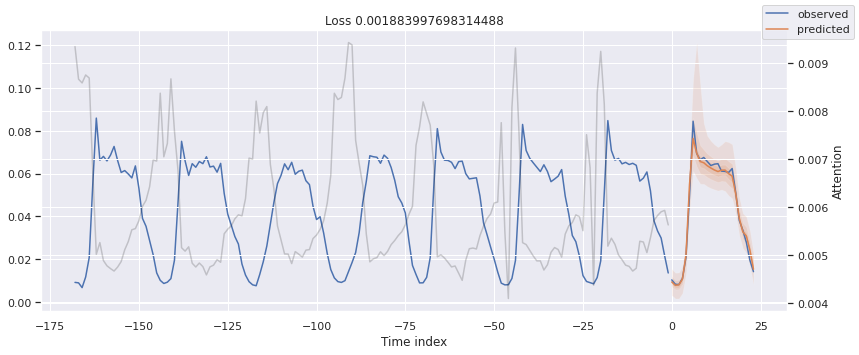

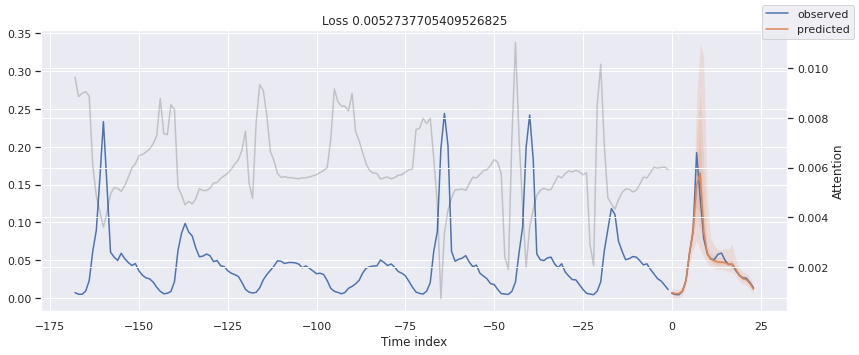

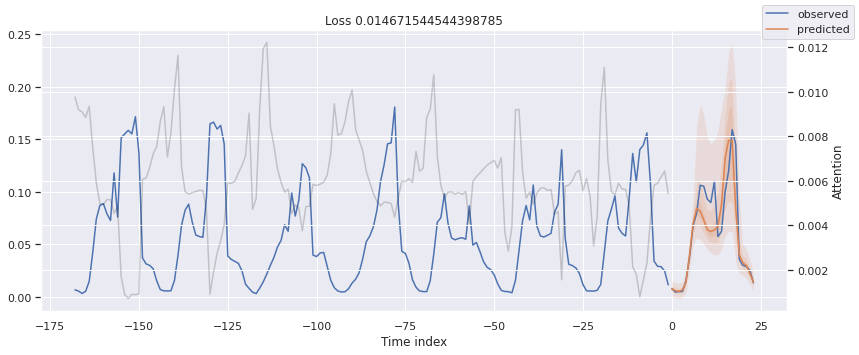

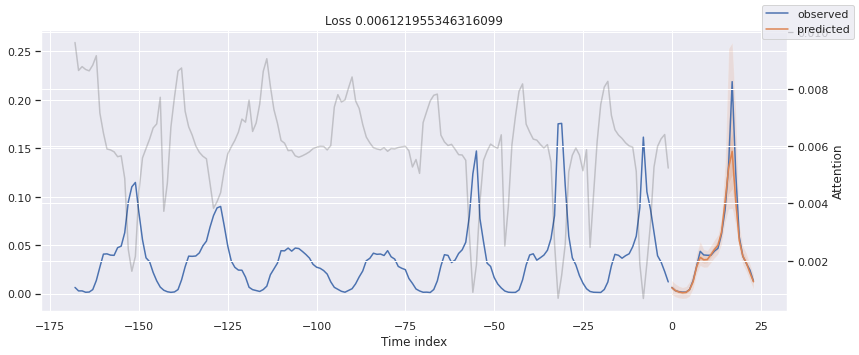

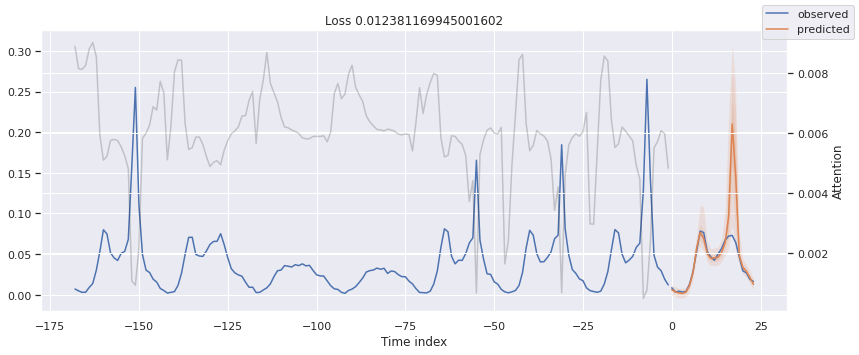

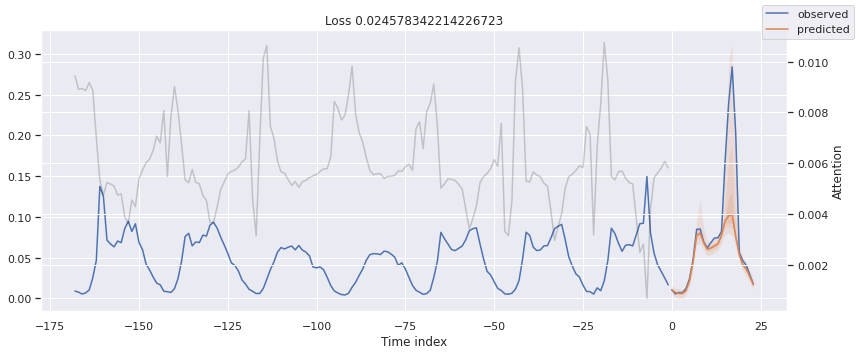

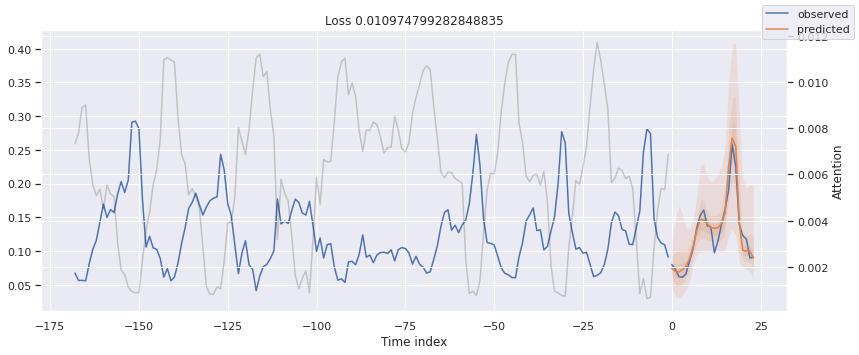

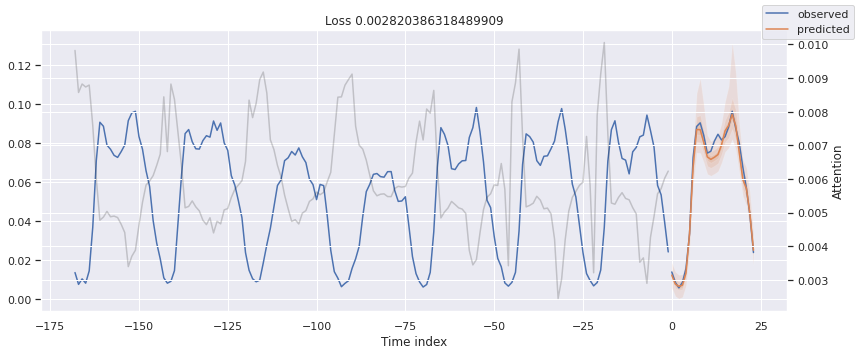

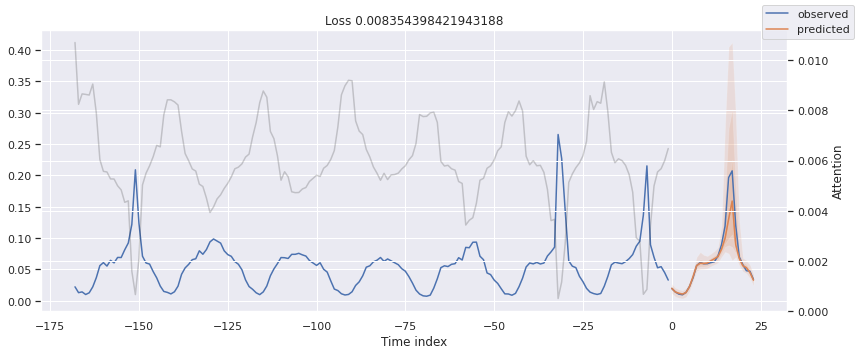

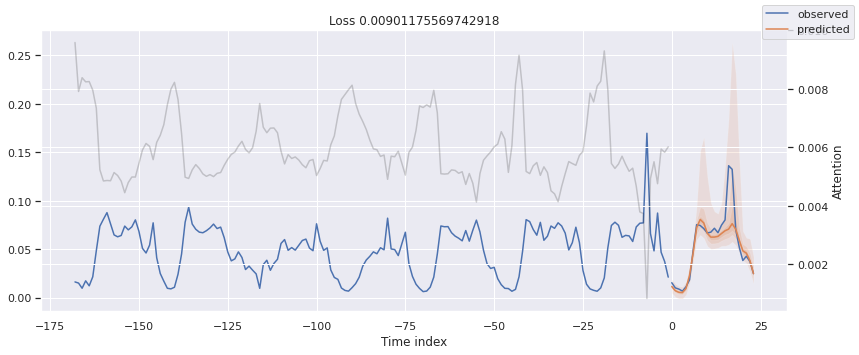

In [ ]:
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

sns.set(rc={'figure.figsize':(12,5)}) # just changing figure size

for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=MAE());

We can also further interpret the attention layer of the model as well as its variables importance:

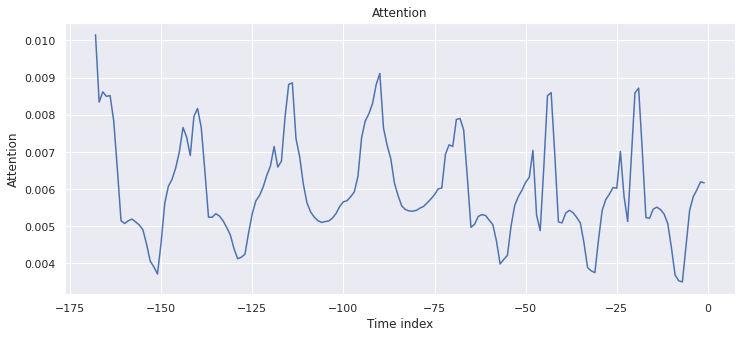

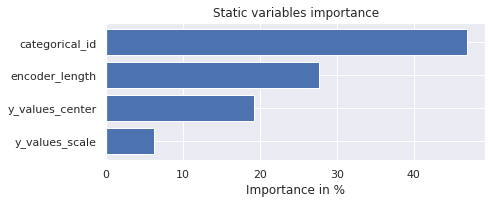

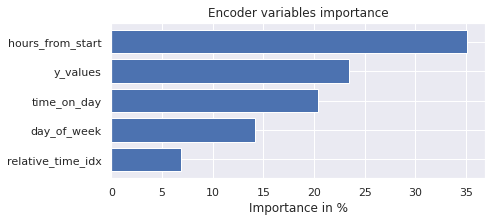

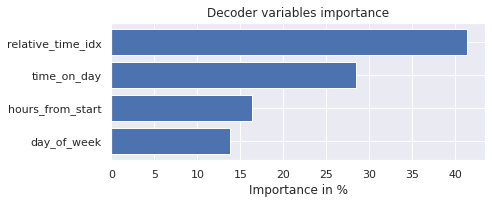

In [ ]:
raw_predictions = best_tft.predict(val_dataloader, mode="raw")

interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
_ = best_tft.plot_interpretation(interpretation)

#### Test with 2 Attention Heads

What would happen if we decreased the number of attention heads to only 2 (keeping the same hidden size as before) ? Let's experiment:

In [11]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("traffic_logs_2attnheads")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=25,
    gpus=1, #1 for gpu
    weights_summary="top", #for printing a summary of the model parameters
    gradient_clip_val=0.1,
    limit_train_batches=320,  # training over batches of 320
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.1,
    hidden_size=320,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=2,
    dropout=0.3,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=64,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=5,
)

print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


Number of parameters in network: 5741.1k


In [12]:
# fit network
trainer.fit(tft, train_dataloader=train_dataloader, val_dataloaders=val_dataloader,)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 72.3 K
3  | prescalers                         | ModuleDict                      | 896   
4  | static_variable_selection          | VariableSelectionNetwork        | 157 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 210 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 158 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 411 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 411 K 
9  | static_context_initial_cell_lstm 

In [13]:
# Loading best achieved model during training (from checkpoint)
best_model_path = trainer.checkpoint_callback.best_model_path #pytorch lightning saved the best
print(best_model_path)
# /Code Notebooks/tft/traffic_logs4/default/version_4/checkpoints/epoch=23-step=7679.ckpt
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

traffic_logs_2attnheads/default/version_0/checkpoints/epoch=21-step=7039.ckpt


In [14]:
# Model evaluation (MAE and RMSE)
score = {"MAE" :  best_tft.logging_metrics[1], 
         "RMSE" : best_tft.logging_metrics[2]}
         
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)

tft_MAE = score["MAE"](predictions, actuals)
tft_RMSE = score["RMSE"](predictions, actuals)

print(f"2-head TFT Model MAE (1 day forecast): {tft_MAE:.7f}")
print(f"2-head TFT Model RMSE (1 day forecast): {tft_RMSE:.7f}")

2-head TFT Model MAE (1 day forecast): 0.0104311
2-head TFT Model RMSE (1 day forecast): 0.0364422


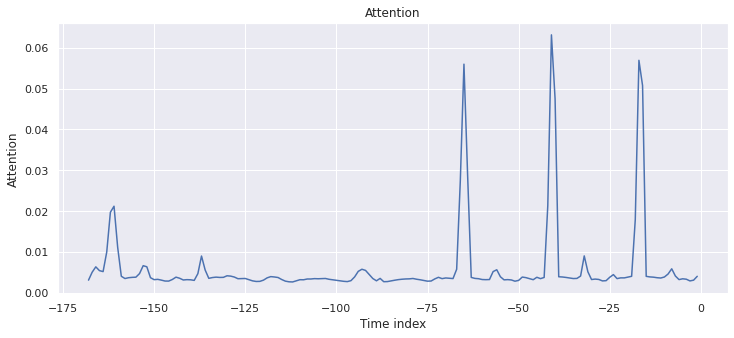

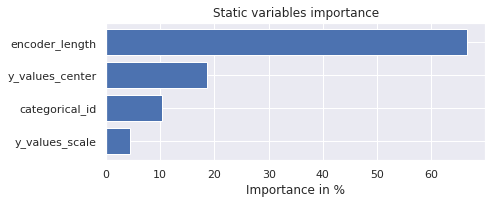

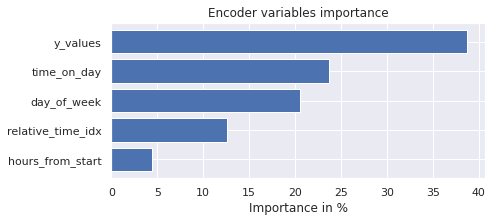

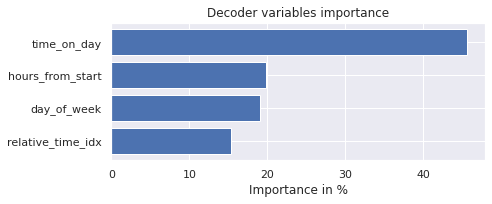

In [16]:
raw_predictions = best_tft.predict(val_dataloader, mode="raw")

interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
_ = best_tft.plot_interpretation(interpretation)

### 1-week Forecast Scenario

Same drill as before, but now predicting for a whole 7 days ahead (max pred. length is now 7 days)

In [17]:
max_prediction_length = 7*24 # predict max 1 week ahead
max_encoder_length = 7*24 #using last 7 days (prior week)

# Sets limit for training data (last index prior to max prediction sequence)
training_cutoff = traffic_df_hourly["hours_from_start"].max() - max_prediction_length

training = TimeSeriesDataSet(
    traffic_df_hourly[lambda x: x.hours_from_start <= training_cutoff],
    time_idx="hours_from_start", # variable that contains the time index
    target="y_values", # target variable to predict
    group_ids=["categorical_id"], # Groups used for later normalizing
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1, # at least we predict 1 time index
    max_prediction_length=max_prediction_length,
    static_categoricals=["categorical_id"], # they do not change along a same time index
    #static_reals=[], # same as before but real values
    time_varying_known_categoricals=["day_of_week"], # cats that change for same time idx
    #variable_groups={},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["time_on_day", "hours_from_start"],
    #time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "y_values"
    ], # values that are not supposed to be known in the future
    target_normalizer=TorchNormalizer(),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True, # to add the center and scale of the unnormalized timeseries as features  TODO change to false
    add_encoder_length=True, # adds decoder length to list of static real variables. 
)

In [18]:
validation = TimeSeriesDataSet.from_dataset(training, traffic_df_hourly, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

We can quickly check the generated time series dataset and dataloaders by executing a simple baseline forecast (naive forecast)

In [ ]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

0.033166103065013885

#### Temporal Fusion Transformer Test (1 week ahead)

In [ ]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=1,
    gradient_clip_val=0.1,
)

# Instantiating model adapted to dataset
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.01,
    hidden_size=320, 
    attention_head_size=4,
    dropout=0.3,  
    hidden_continuous_size=128, 
    output_size=7, 
    loss=QuantileLoss(),
    reduce_on_plateau_patience=5,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 42
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning:

You have set progress_bar_refresh_rate < 20 on Google Colab. This may crash. Consider using progress_bar_refresh_rate >= 20 in Trainer.

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Number of parameters in network: 6350.2k



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 72.3 K
3  | prescalers                         | ModuleDict                      | 1.8 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 355 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 475 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 356 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 411 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 411 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 411 

Restored states from the checkpoint file at /content/drive/My Drive/Máster Big Data (2020-2021)/TFM/Code Notebooks/tft/lr_find_temp_model.ckpt


suggested learning rate: 0.0019498445997580445


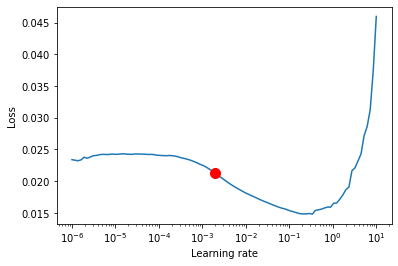

In [ ]:
# find optimal learning rate
res = trainer.tuner.lr_find(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [ ]:
# to solve issue on training (library issue)
import tensorflow as tf 
import tensorboard as tb 
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

We can use Tensorboard panel to visualize how training is going and detect possible issues while executing the model's training:

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
%tensorboard --logdir traffic_logs_1week_1

In [ ]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("traffic_logs_1week_1")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=25,
    gpus=1,
    weights_summary="top", #for printing a summary of the model parameters
    gradient_clip_val=0.1,
    limit_train_batches=320,  # training over batches of 320
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.1, # it will log-decay each 5 steps with no improvement
    hidden_size=320,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=4,
    dropout=0.3,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=64,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=5,
)

print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning:

You have set progress_bar_refresh_rate < 20 on Google Colab. This may crash. Consider using progress_bar_refresh_rate >= 20 in Trainer.

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Number of parameters in network: 5689.8k


In [ ]:
trainer.fit(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)

Once the trainer has found best model parameters, we will retrieve it and also keep a look on the path where it has been stored (for later usage without having to retrain the model).

In [ ]:
# Loading best achieved model during training (from checkpoint)
#best_model_path = trainer.checkpoint_callback.best_model_path #pytorch lightning saved the best
best_model_path = "../../trained_models/tft_model_traffic_1week.ckpt"
print(best_model_path) # store best model from this path in repo for later use (no waiting time)
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

../../trained_models/tft_model_traffic_1week.ckpt


In [ ]:
# Model evaluation (MAE and RMSE)
score = {"MAE" :  best_tft.logging_metrics[1], 
         "RMSE" : best_tft.logging_metrics[2]}
         
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)

tft_MAE_1week = score["MAE"](predictions, actuals)
tft_RMSE_1week = score["RMSE"](predictions, actuals)

print(f"TFT Model MAE (1 week forecast): {tft_MAE_1week:.7f}")
print(f"TFT Model RMSE (1 week forecast): {tft_RMSE_1week:.7f}")

TFT Model MAE (1 week forecast): 0.0105448
TFT Model RMSE (1 week forecast): 0.0365866


Again, we can particularize the predictions to those of the target road sensor id 0 (the one analyzed in the clasical forecasting models) as follows:

In [ ]:
raw_predictions, x, indx = best_tft.predict(val_dataloader, return_index=True, mode="raw", return_x=True)

sns.set(rc={'figure.figsize':(12,5)}) 

# we specify the desired index, and also plot avg MAE and RMSE errors for it
best_tft.plot_prediction(x, raw_predictions, idx=0, add_loss_to_title=MAE());
best_tft.plot_prediction(x, raw_predictions, idx=0, add_loss_to_title=RMSE());

#### Interpreting the TFT model and 1 week forecast

Let's now also take a look at the rest of the road sensors and their forecast plots:

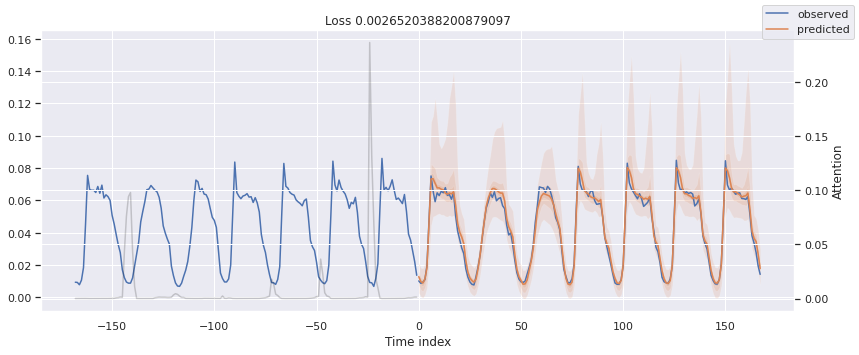

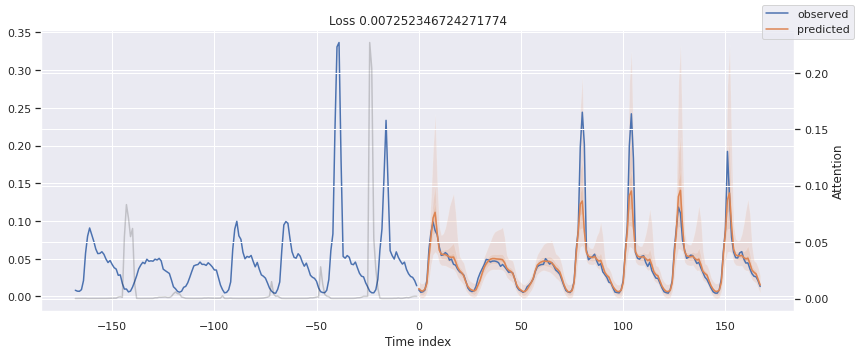

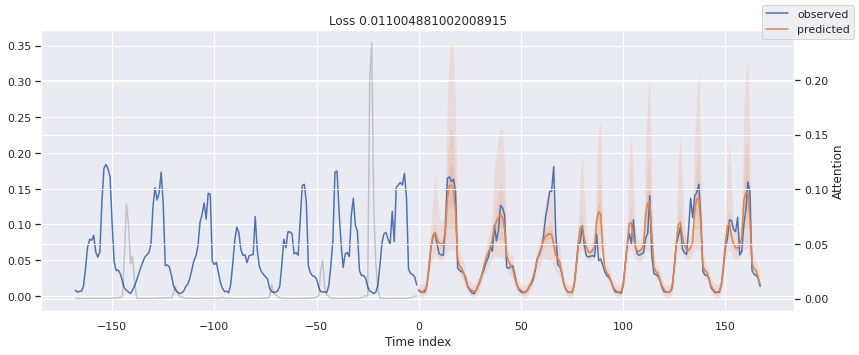

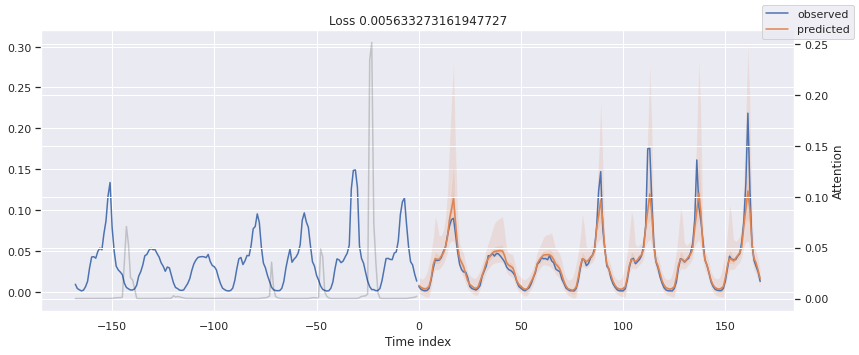

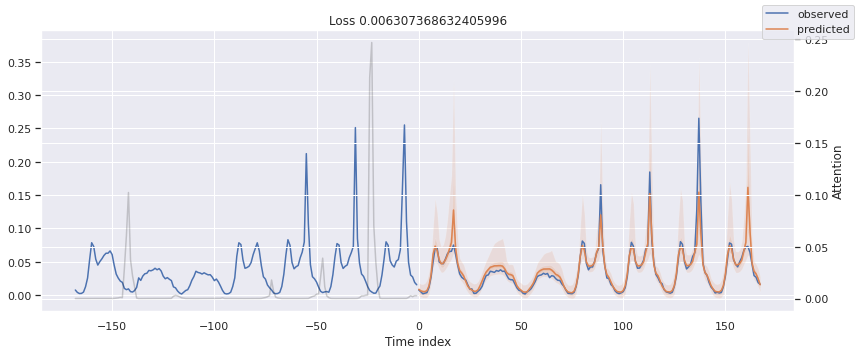

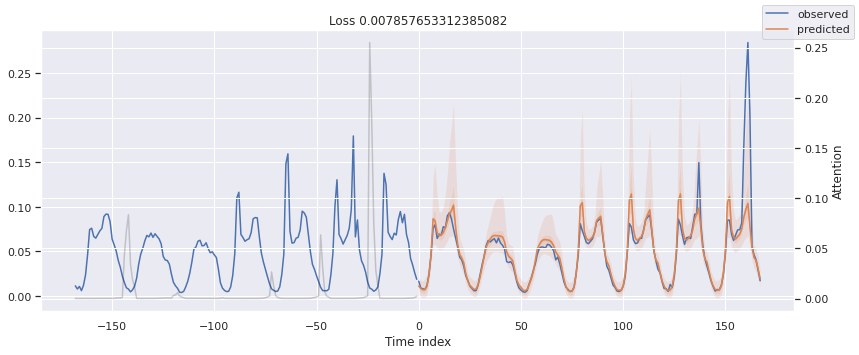

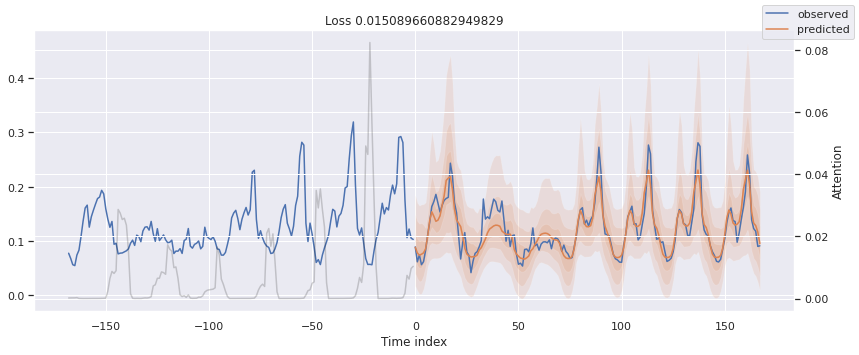

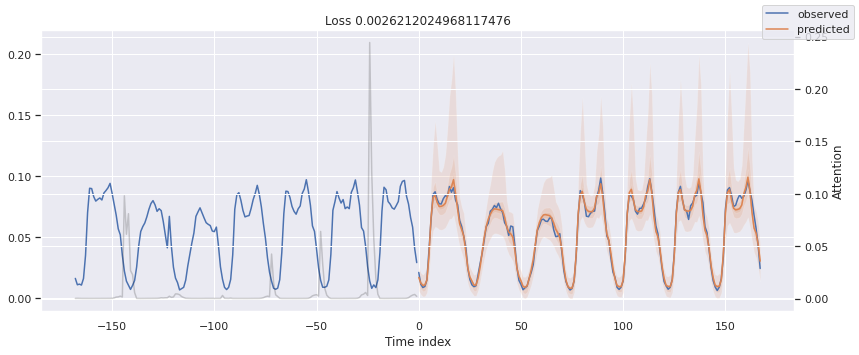

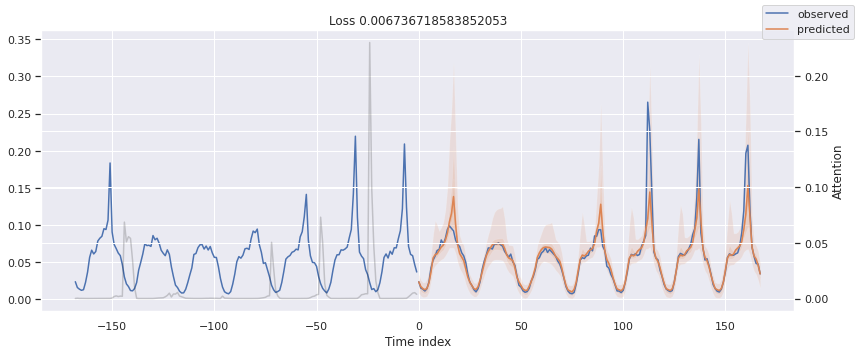

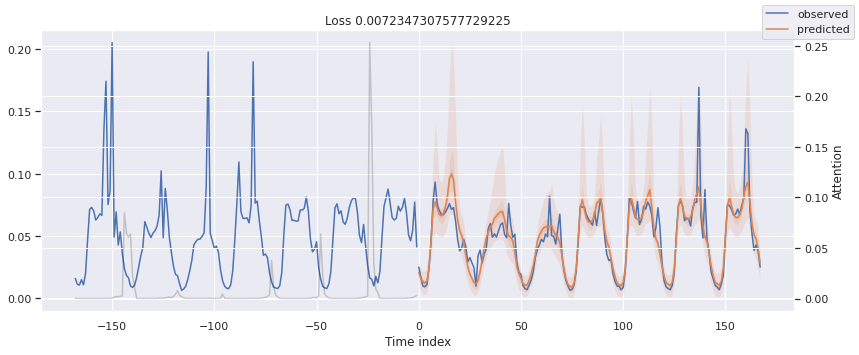

In [ ]:
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

sns.set(rc={'figure.figsize':(12,5)}) # just changing figure size

for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=MAE());

Again, we can also further interpret the attention layer of the model as well as its variables importance:

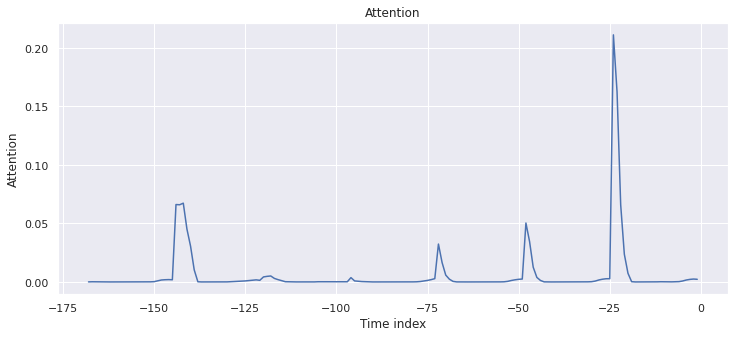

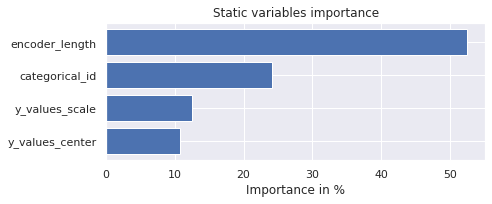

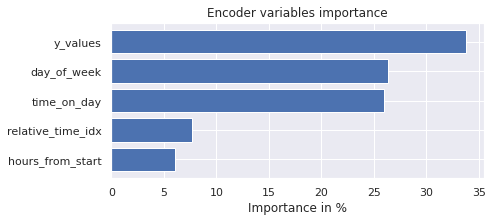

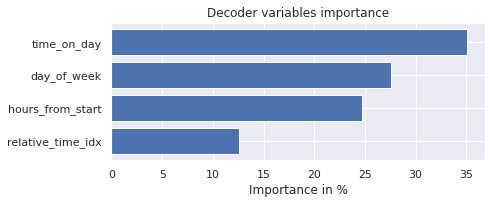

In [ ]:
raw_predictions = best_tft.predict(val_dataloader, mode="raw")

interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
_ = best_tft.plot_interpretation(interpretation)

#### Test with 2 Attention Heads

In [23]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("traffic_logs_1week_2attnheads")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=25,
    gpus=1, #1 for gpu
    weights_summary="top", #for printing a summary of the model parameters
    gradient_clip_val=0.1,
    limit_train_batches=320,  # training over batches of 320
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.1,
    hidden_size=320,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=2,
    dropout=0.3,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=64,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=5,
)

print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


Number of parameters in network: 5741.1k


In [24]:
# fit network
trainer.fit(tft, train_dataloader=train_dataloader, val_dataloaders=val_dataloader,)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 72.3 K
3  | prescalers                         | ModuleDict                      | 896   
4  | static_variable_selection          | VariableSelectionNetwork        | 157 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 210 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 158 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 411 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 411 K 
9  | static_context_initial_cell_lstm 

In [25]:
# Loading best achieved model during training (from checkpoint)
best_model_path = trainer.checkpoint_callback.best_model_path #pytorch lightning saved the best
print(best_model_path)
# /Code Notebooks/tft/traffic_logs4/default/version_4/checkpoints/epoch=23-step=7679.ckpt
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

traffic_logs_1week_2attnheads/default/version_0/checkpoints/epoch=24-step=7999.ckpt


In [26]:
# Model evaluation (MAE and RMSE)
score = {"MAE" :  best_tft.logging_metrics[1], 
         "RMSE" : best_tft.logging_metrics[2]}
         
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)

tft_MAE = score["MAE"](predictions, actuals)
tft_RMSE = score["RMSE"](predictions, actuals)

print(f"2-head TFT Model MAE (1 week forecast): {tft_MAE:.7f}")
print(f"2-head TFT Model RMSE (1 week forecast): {tft_RMSE:.7f}")

2-head TFT Model MAE (1 week forecast): 0.0064698
2-head TFT Model RMSE (1 week forecast): 0.0205757


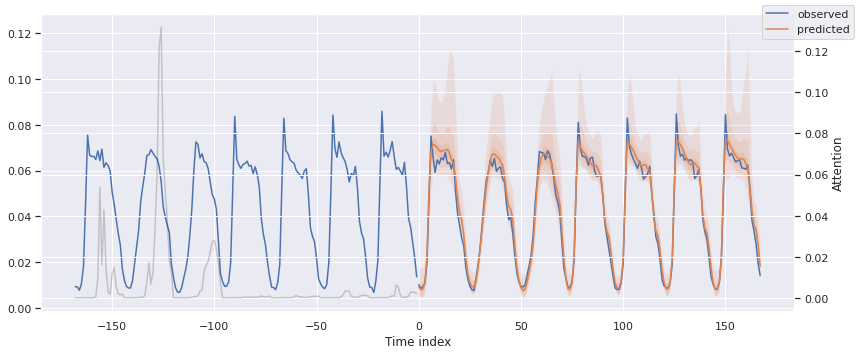

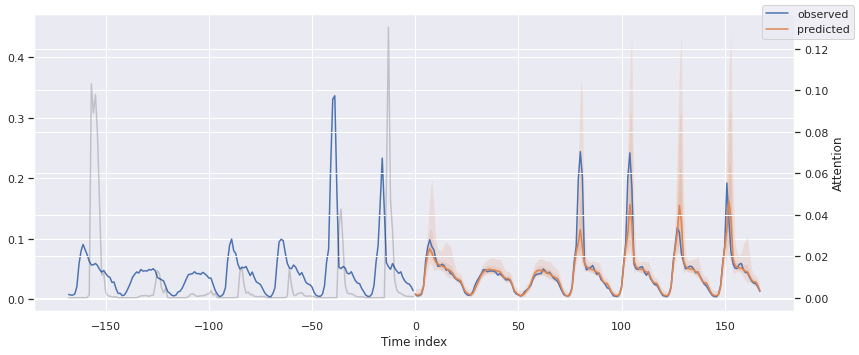

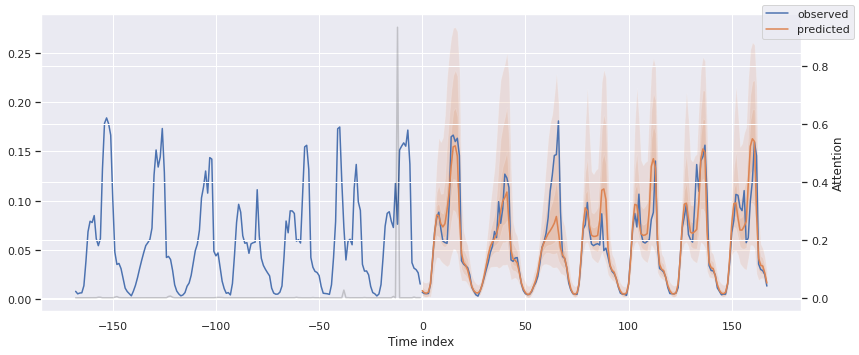

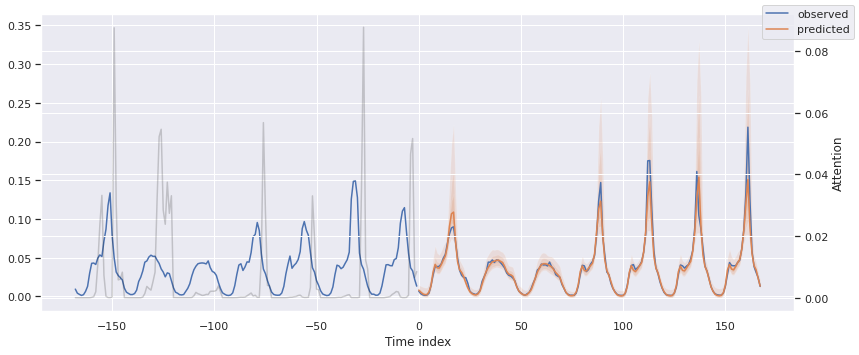

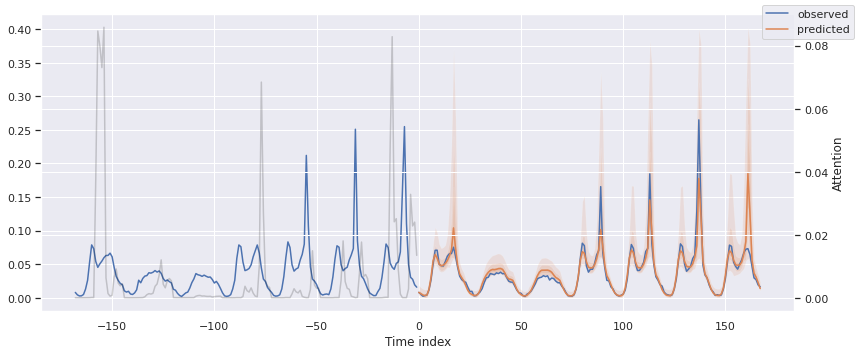

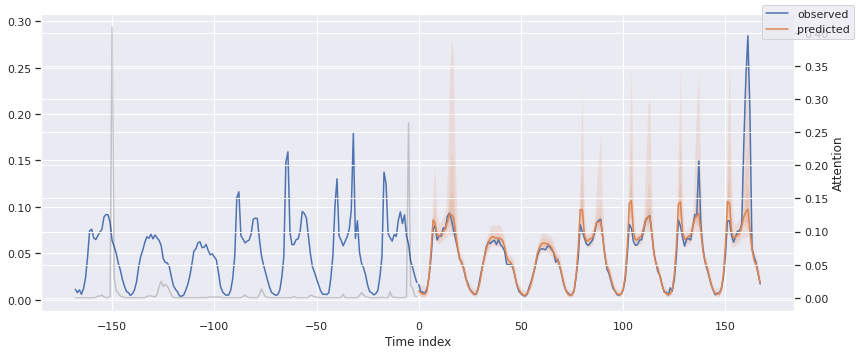

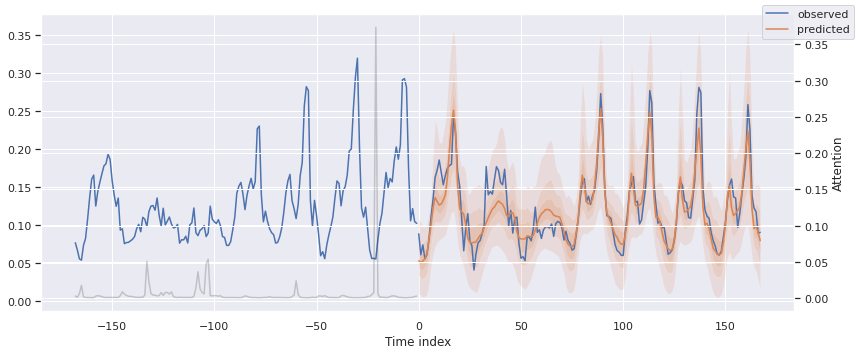

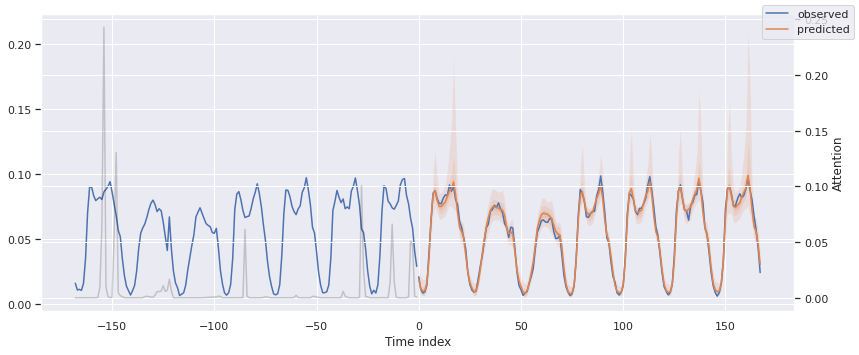

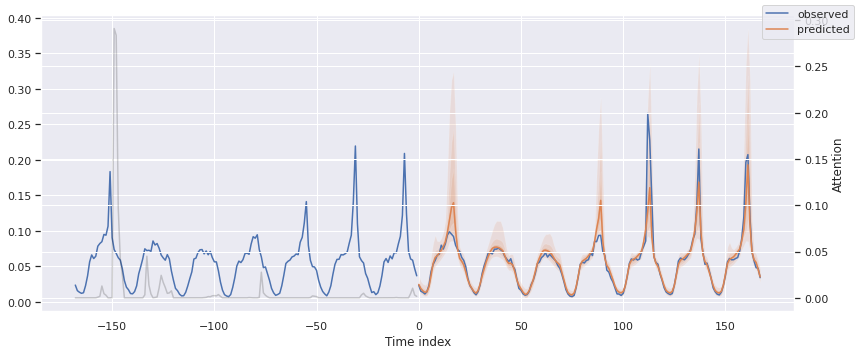

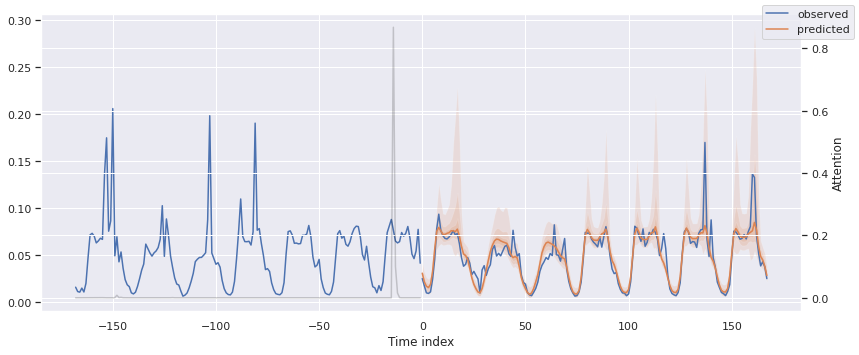

In [29]:
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

sns.set(rc={'figure.figsize':(12,5)})

for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx);

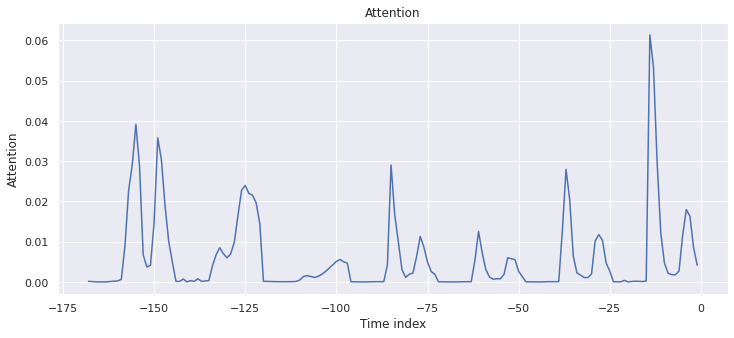

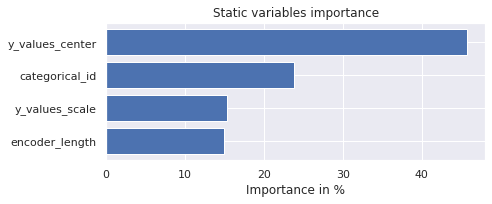

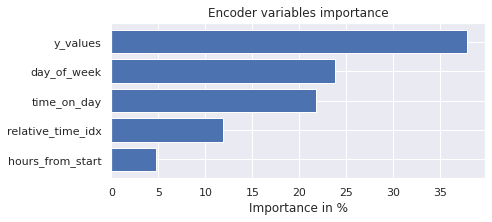

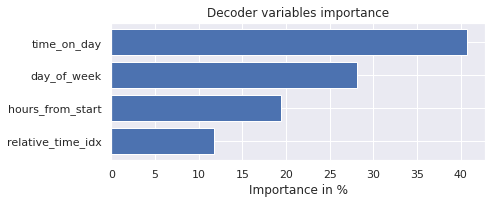

In [27]:
raw_predictions = best_tft.predict(val_dataloader, mode="raw")

interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
_ = best_tft.plot_interpretation(interpretation)



---


## Electricity Dataset

**Note*: Data retrieval, aggregation and exploration done in the other notebook.

### Loading aggregated data

As processed in the notebook provided ' '...

In [14]:
electr_df_hourly = pd.read_csv("../data/electr/hourly_electricity.csv", index_col=0)
electr_df_hourly

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



power_usage        t  ...  categorical_day_of_week categorical_hour
17544         2.538071  26304.0  ...                        2                0
17545         2.855330  26305.0  ...                        2                1
17546         2.855330  26306.0  ...                        2                2
17547         2.855330  26307.0  ...                        2                3
17548         2.538071  26308.0  ...                        2                4
...                ...      ...  ...                      ...              ...
10461482  20824.324324  32299.0  ...                        6               19
10461483  19527.027027  32300.0  ...                        6               20
10461484  20202.702703  32301.0  ...                        6               21
10461485  19851.351351  32302.0  ...                        6               22
10461486  20135.135135  32303.0  ...                        6               23

[2198072 rows x 13 columns]

We can check how Google-Research experiment formatted their data:

```
# From tft/data_formatters/electricity.py:

_column_definition = [
    ('id', DataTypes.REAL_VALUED, InputTypes.ID),
    ('hours_from_start', DataTypes.REAL_VALUED, InputTypes.TIME),
    ('power_usage', DataTypes.REAL_VALUED, InputTypes.TARGET),
    ('hour', DataTypes.REAL_VALUED, InputTypes.KNOWN_INPUT),
    ('day_of_week', DataTypes.REAL_VALUED, InputTypes.KNOWN_INPUT),
    ('hours_from_start', DataTypes.REAL_VALUED, InputTypes.KNOWN_INPUT),
    ('categorical_id', DataTypes.CATEGORICAL, InputTypes.STATIC_INPUT),
]

# from tft/libs/tft_model.py#L708 (function "_batch_data()"):

   id_col = self._get_single_col_by_type(InputTypes.ID)
    time_col = self._get_single_col_by_type(InputTypes.TIME)
    target_col = self._get_single_col_by_type(InputTypes.TARGET)
    input_cols = [
        tup[0]
        for tup in self.column_definition
        if tup[2] not in {InputTypes.ID, InputTypes.TIME}
    ]
```



In other words, we have that:

- **id column** is referred to as per-station identifier (MT_XXX) (**'*id*'**) attribute. All data is grouped per station.
- **time column** is the time index, being it the '***hours_from_start***' attribute
- **target column** is the value we want to predict (the *y*). In this case, the '***power_usage***' attribute.
- **input columns** are the set of predictors used in the model:
    - *'**hour**', '**day_of_week**', '**hours_from_start**'* and '***categorical_id***'

I have observed that '***categorical_id***' is just an integer label encoding for the **'*id*'** attribute (Station ID).

### TimeSeriesDataset Creation (Pytorch-Forecasting Compatibility)

We have to do a similar treatment to our data as with the previous dataset, however we have some differences to take into account.

In [ ]:
# Checking data grouped by id
electr_df_hourly.groupby(by='id').describe()

power_usage                                  ... categorical_hour                   
             count          mean          std  min  ...              25%   50%    75%   max
id                                                  ...                                    
MT_001      6000.0      4.656885     5.842070  0.0  ...             5.75  11.5  17.25  23.0
MT_002      6000.0     27.472588     5.890997  0.0  ...             5.75  11.5  17.25  23.0
MT_003      6000.0      1.715356     0.297864  0.0  ...             5.75  11.5  17.25  23.0
MT_004      6000.0    120.573001    36.902810  0.0  ...             5.75  11.5  17.25  23.0
MT_005      6000.0     50.958384    18.275798  0.0  ...             5.75  11.5  17.25  23.0
...            ...           ...          ...  ...  ...              ...   ...    ...   ...
MT_366      6000.0     11.109908     8.397007  0.0  ...             5.75  11.5  17.25  23.0
MT_367      6000.0    565.371013   141.825562  0.0  ...             5.75  11.5  17.25  23.0
MT_368      6000.0    126.249374    68.592420  0.0  ...             5.75  11.5  17.25  23.0
MT_369      6000.0    815.331562   139.684689  0.0  ...             5.75  11.5  17.25  23.0
MT_370      6000.0  17806.094595  3760.770898  0.0  ...             5.75  11.5  17.25  23.0

[369 rows x 80 columns]

Now data is grouped by 'stations' (each station has different electricity consumption readings, that is, the individual time series).

Some variable understanding checks...

In [ ]:
total_t = 32303-26304 # each t is 1 hr
total_days = 1345-1096
total_t//24, total_days

(249, 249)

In [ ]:
electr_df_hourly.t.astype(int).min(), electr_df_hourly.t.max()

(26304, 32303.0)

#### Setting up variables datatypes

As before, now we have to convert the dataframe into a PyTorch Forecasting **TimeSeriesDataSet**. This is via specifying first relevant attributes, datatypes, target variable, etc.

First, some attributes need specific formatting (datatype conversion,...)

In [15]:
# Setting up time index (from 0 to max (5999))
electr_df_hourly["time_idx"] = (electr_df_hourly["t"] - electr_df_hourly["t"].min()).astype(int)

# Converting all features to desired datatyoe (categorical, int, ...)
electr_df_hourly["hour"] = electr_df_hourly["hour"].astype(int)
electr_df_hourly["day_of_week"] = electr_df_hourly["day_of_week"].astype(str).astype("category")
electr_df_hourly["hours_from_start"] = electr_df_hourly["hours_from_start"].astype(int)
electr_df_hourly["id"] = electr_df_hourly["id"].astype("category")
electr_df_hourly["categorical_id"] = electr_df_hourly["categorical_id"].astype("category")

### 1-day Electricity consumption Forecast Scenario

#### Declaring TimeSeriesDataset Object

Again, here **parameters are adjusted based on author's recommended settings** for this dataset (found in paper).

In [16]:
max_prediction_length = 24
max_encoder_length = 7*24

training_cutoff = electr_df_hourly["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    electr_df_hourly[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx", # variable that contains the time index
    target="power_usage", # target variable to predict
    group_ids=["id"], # Groups used for later normalizing
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1, # at least we predict 1 time index
    max_prediction_length=max_prediction_length,
    static_categoricals=["id","categorical_id"], # they do not change along a same time index
    time_varying_known_categoricals=["day_of_week"], # cats that change for same time idx
    time_varying_known_reals=["time_idx", "hours_from_start", "hour"],
    time_varying_unknown_reals=[
        "power_usage"
    ],
    target_normalizer=GroupNormalizer(
        groups=["id"], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True, # to add the center and scale of the unnormalized timeseries as features
    add_encoder_length=True, # adds decoder length to list of static real variables. 
)

In [17]:
validation = TimeSeriesDataSet.from_dataset(training, electr_df_hourly, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

#### Baseline (Naive forecast) Test

Again, we can check our implemented time series dataset with the simple naive forecast:

In [ ]:
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

289.6158447265625

#### Temporal Fusion Transformer Test


From TFT GoogleResearch experiment, they used the following parameters:

```
    fixed_params = {
        'total_time_steps': 8 * 24,
        'num_encoder_steps': 7 * 24,
        'num_epochs': 100,
        'early_stopping_patience': 5,
        'multiprocessing_workers': 5
    }
    model_params = {
        'dropout_rate': 0.1,
        'hidden_layer_size': 160,
        'learning_rate': 0.001,
        'minibatch_size': 64,
        'max_gradient_norm': 0.01,
        'num_heads': 4,
        'stack_size': 1
    }


We will use a very similar structure and parameters (learning rate will be adaptive so we will set it a bit higher, and log-decrease each 4 epochs on plateau)

In [ ]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=1,
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.01,
    hidden_size=160,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=4,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=160,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 42
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning:

You have set progress_bar_refresh_rate < 20 on Google Colab. This may crash. Consider using progress_bar_refresh_rate >= 20 in Trainer.

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Number of parameters in network: 2569.3k



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 32.5 K
3  | prescalers                         | ModuleDict                      | 2.6 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 314 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 524 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 419 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 103 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 103 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 103 

Restored states from the checkpoint file at /content/drive/My Drive/Máster Big Data (2020-2021)/TFM/Code Notebooks/tft/lr_find_temp_model.ckpt


suggested learning rate: 4.073802778041128e-05


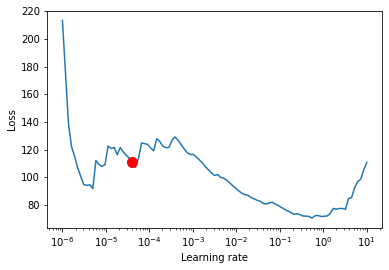

In [ ]:
res = trainer.tuner.lr_find(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [ ]:
# to solve issue on training
import tensorflow as tf 
import tensorboard as tb 
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
%tensorboard --logdir electricity_logs

(check [Fast Training of pytorch_lightning Trainer module](https://pytorch-lightning.readthedocs.io/en/stable/common/fast_training.html))

Now we can configure the original network, and start fitting:

In [ ]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("electricity_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=30,
    gpus=1,
    weights_summary="top",
    gradient_clip_val=0.1,
    limit_train_batches=300,  # coment in for training, running valiation every 300 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training, # train time series dataset
    learning_rate=0.01,
    hidden_size=160,
    attention_head_size=4, #attention heads
    dropout=0.1,
    hidden_continuous_size=160,
    output_size=7,  # 7 quantiles
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)

print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning:

You have set progress_bar_refresh_rate < 20 on Google Colab. This may crash. Consider using progress_bar_refresh_rate >= 20 in Trainer.

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Number of parameters in network: 2569.3k


In [ ]:
# fit network
trainer.fit(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)

In [ ]:
# Loading best achieved model during training (from checkpoint)
#best_model_path = trainer.checkpoint_callback.best_model_path
best_model_path = "../../trained_models/tft_model_electr_1day.ckpt"
# /TFM/Code Notebooks/tft/electricity_logs/default/version_0/checkpoints/epoch=20-step=6299.ckpt
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

Recall: we have here normalized the data; hence the MAE and validation losses are normalized values. We should inverse the transformation (normalization) to compare with the other models.

In [ ]:
# Model evaluation (MAE and RMSE)
score = {"MAE" :  best_tft.logging_metrics[1], 
         "RMSE" : best_tft.logging_metrics[2]}
         
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)

tft_MAE = score["MAE"](predictions, actuals)
tft_RMSE = score["RMSE"](predictions, actuals)

print(f"TFT Model MAE (1 day forecast): {tft_MAE:.7f}")
print(f"TFT Model RMSE (1 day forecast): {tft_RMSE:.7f}")

TFT Model MAE (1 day forecast): 37.0945969
TFT Model RMSE (1 day forecast): 230.0595703


We can particularize the predictions to those of the target station MT_320 (the one analyzed in the clasical forecasting models) as follows:

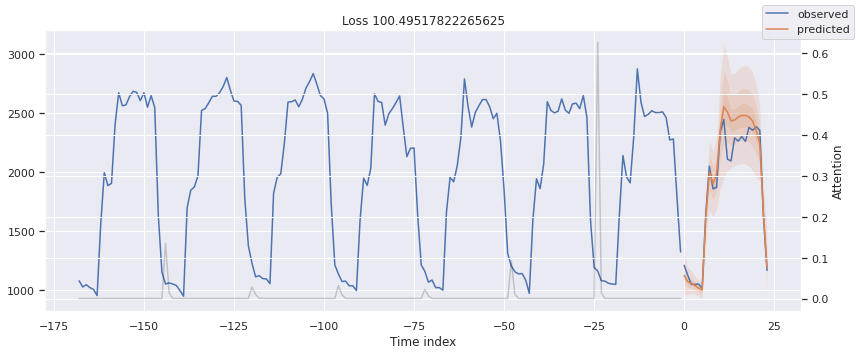

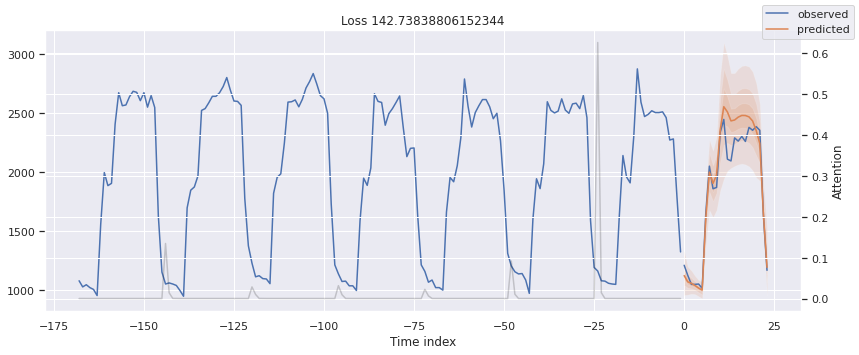

In [ ]:
raw_predictions, x, indx = best_tft.predict(val_dataloader, return_index=True, mode="raw", return_x=True)

sns.set(rc={'figure.figsize':(12,5)}) 

# Index 321 corresponds to station MT_320 analyzed in the previous notebooks
# we plot a validation batch, and the average losses (title)
best_tft.plot_prediction(x, raw_predictions, idx=321, add_loss_to_title=MAE());
best_tft.plot_prediction(x, raw_predictions, idx=321, add_loss_to_title=RMSE());

And let's also visualize the forecasts for some of the other cases:

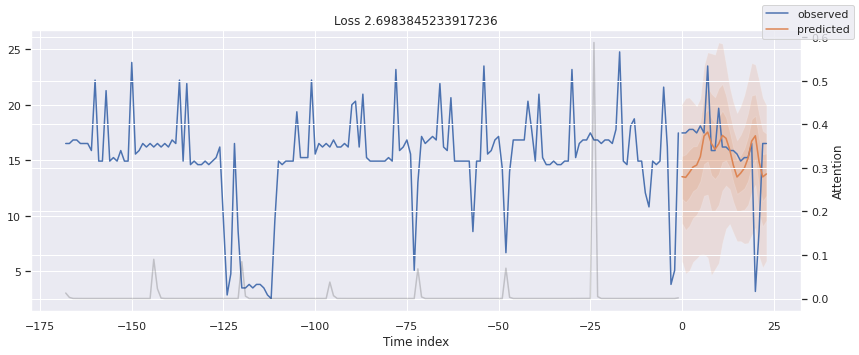

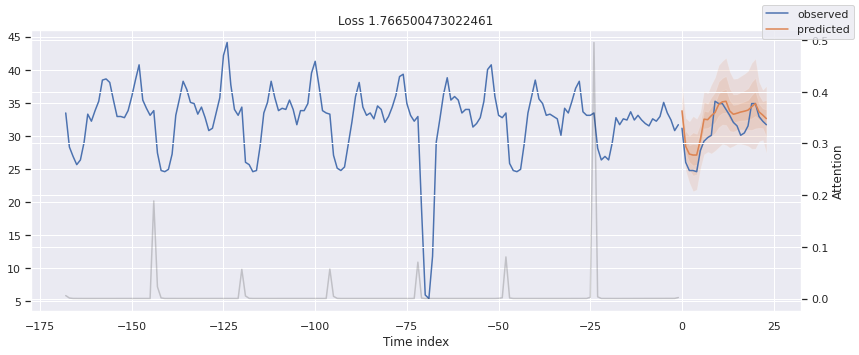

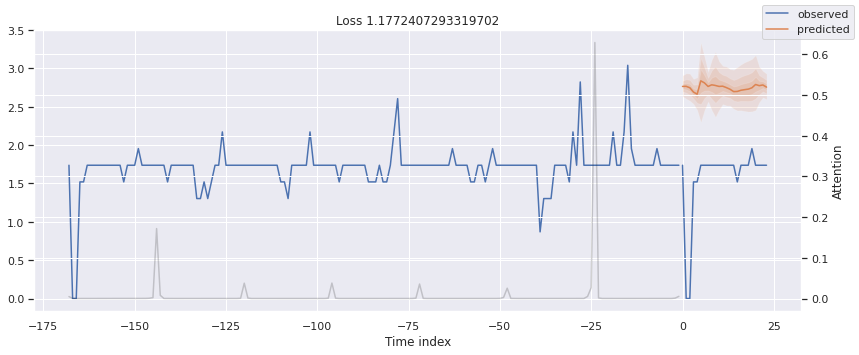

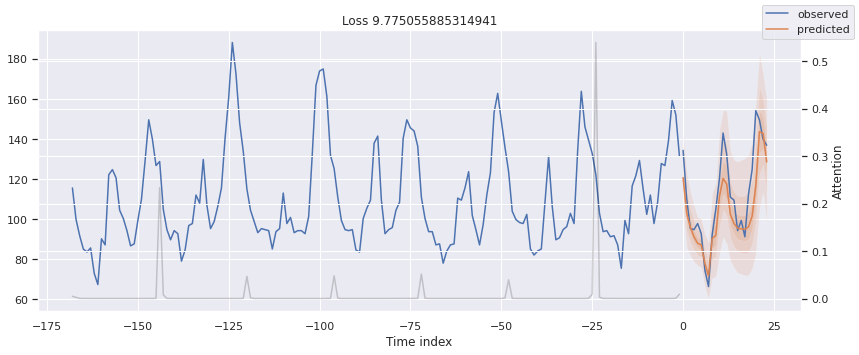

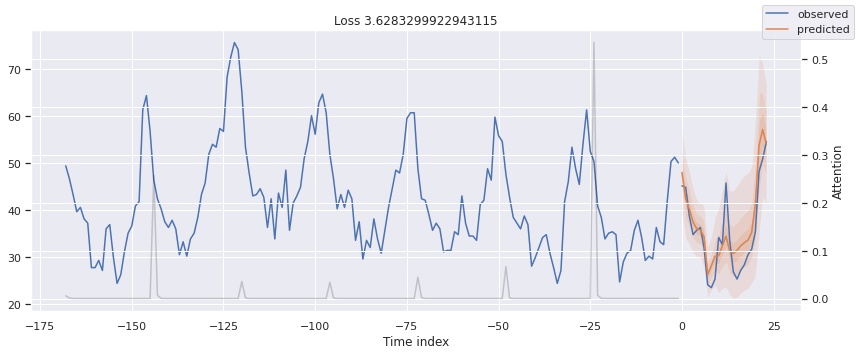

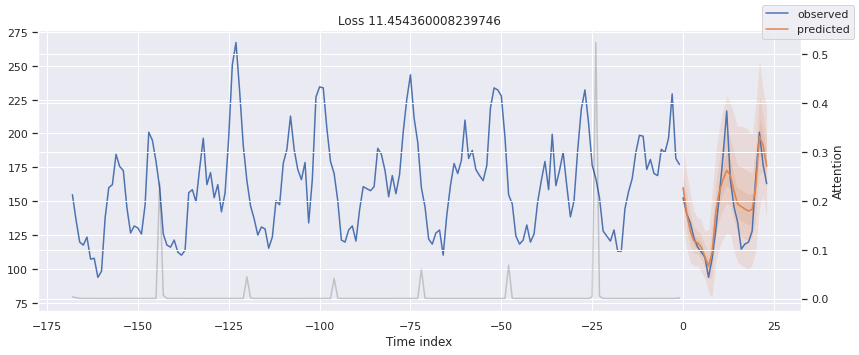

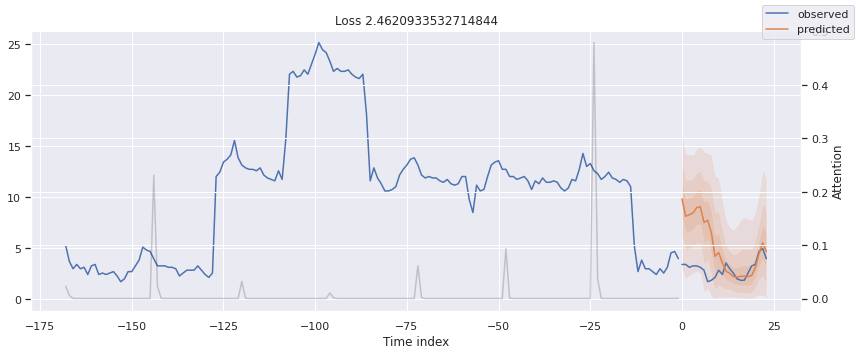

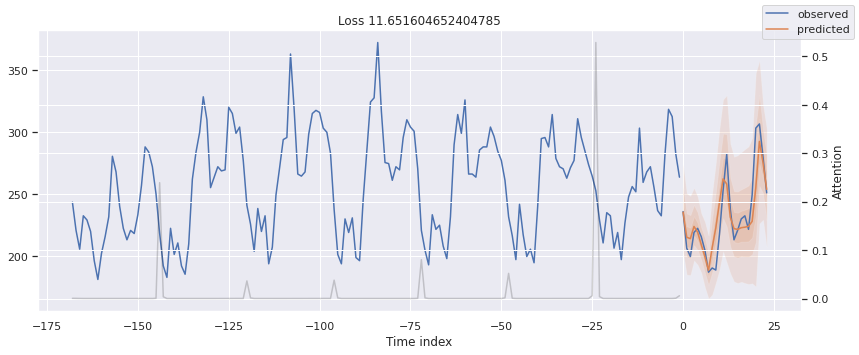

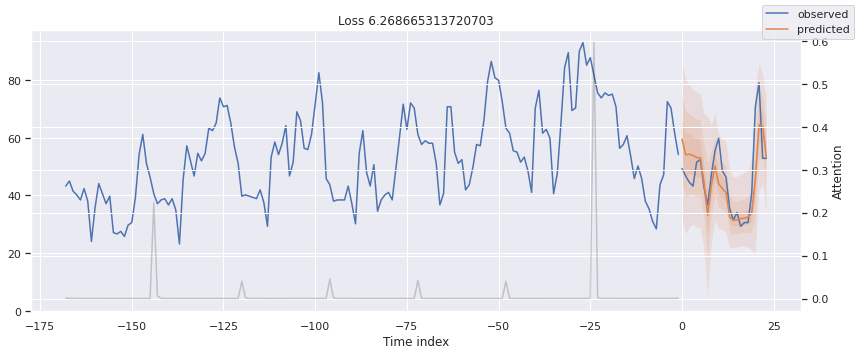

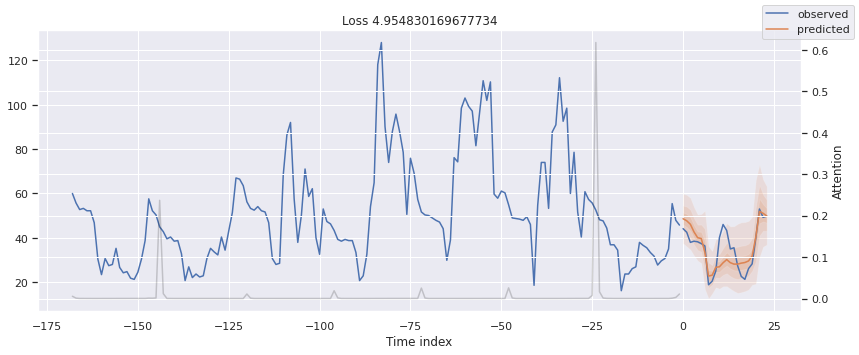

In [ ]:
# Visualizing some of the forecasts for other stations

# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

sns.set(rc={'figure.figsize':(12,5)}) # just changing figure size

for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=MAE());

#### Interpreting the TFT model and predictions

We can also further interpret the model by looking at the attention layer, and variables importance:

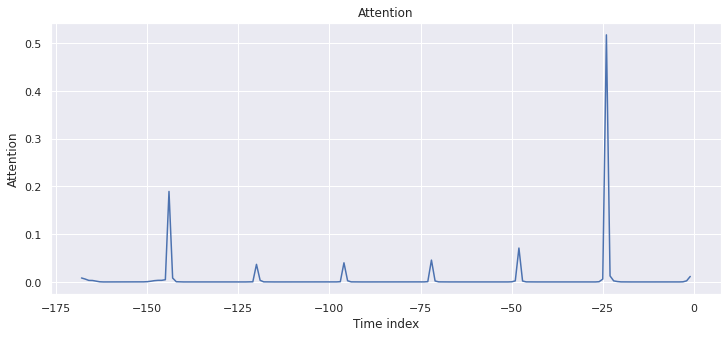

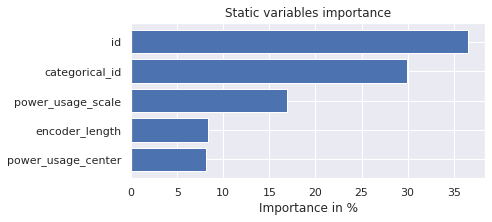

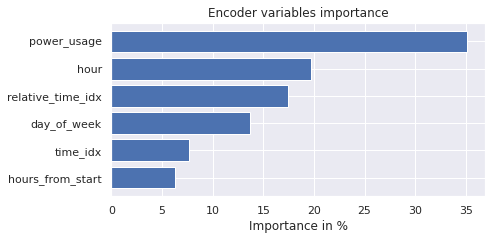

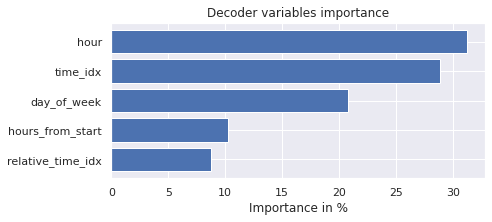

In [ ]:
raw_predictions = best_tft.predict(val_dataloader, mode="raw")

interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
_ = best_tft.plot_interpretation(interpretation)

#### Test with 2 Attention Heads

In [34]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("electricity_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=30,
    gpus=1,
    weights_summary="top",
    gradient_clip_val=0.1,
    limit_train_batches=300,  # coment in for training, running valiation every 300 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training, # train time series dataset
    learning_rate=0.01,
    hidden_size=160,
    attention_head_size=2, #attention heads
    dropout=0.1,
    hidden_continuous_size=160,
    output_size=7,  # 7 quantiles
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)

print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


Number of parameters in network: 2582.1k


In [ ]:
# fit network
trainer.fit(tft, train_dataloader=train_dataloader,val_dataloaders=val_dataloader)

In [18]:
# Loading best achieved model during training (from checkpoint)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [19]:
# Model evaluation (MAE and RMSE)
score = {"MAE" :  best_tft.logging_metrics[1], 
         "RMSE" : best_tft.logging_metrics[2]}
         
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)

tft_MAE = score["MAE"](predictions, actuals)
tft_RMSE = score["RMSE"](predictions, actuals)

print(f"2-head TFT Model MAE (1 day forecast): {tft_MAE:.7f}")
print(f"2-head TFT Model RMSE (1 day forecast): {tft_RMSE:.7f}")

2-head TFT Model MAE (1 day forecast): 36.0599480
2-head TFT Model RMSE (1 day forecast): 215.8059845


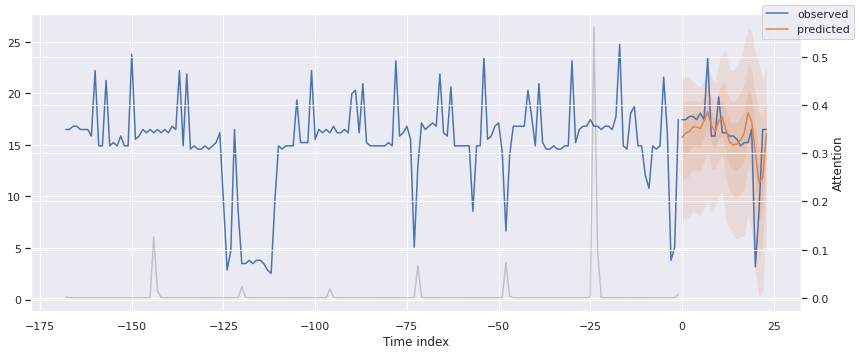

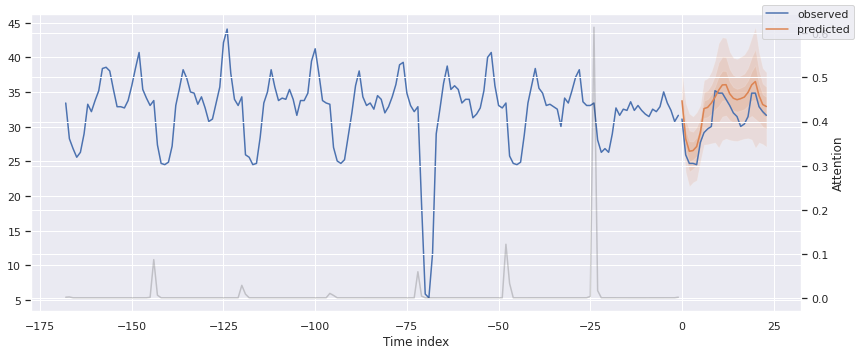

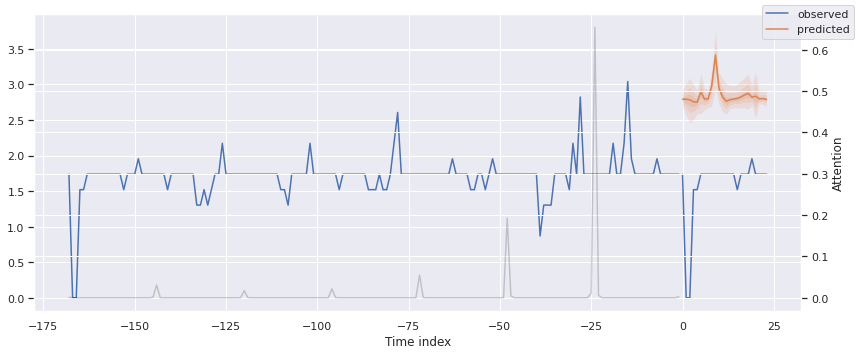

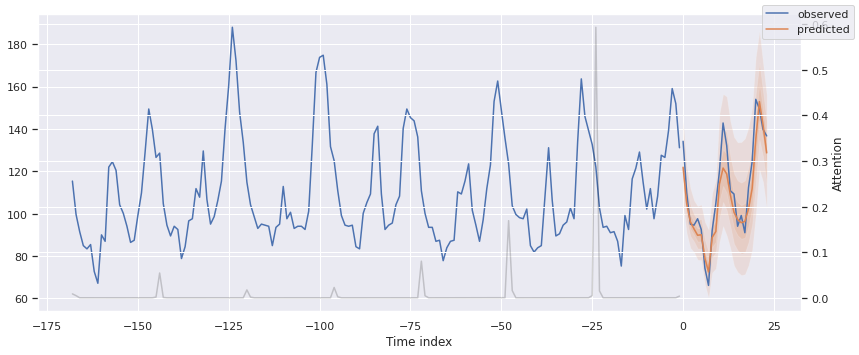

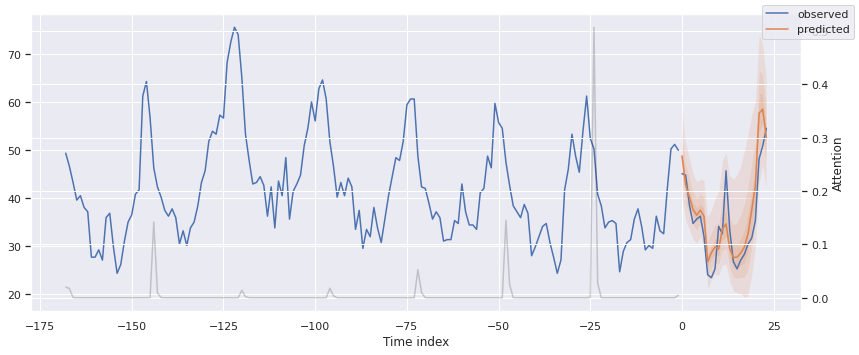

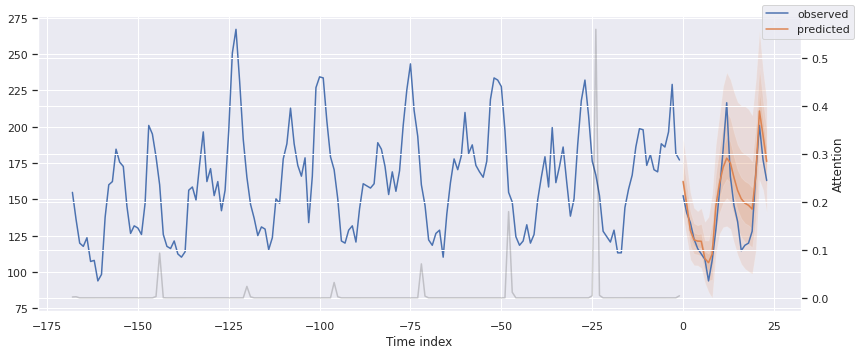

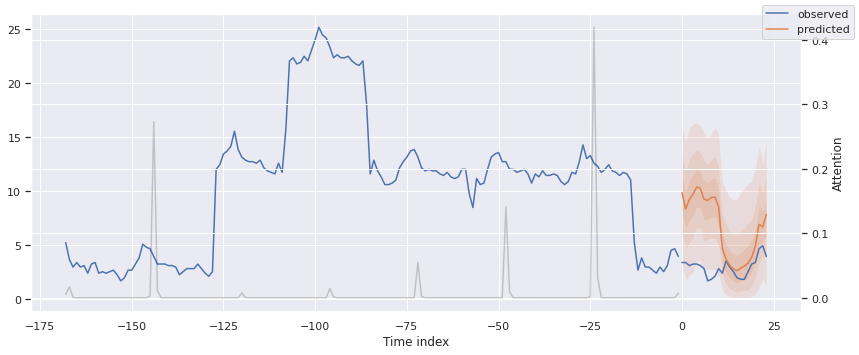

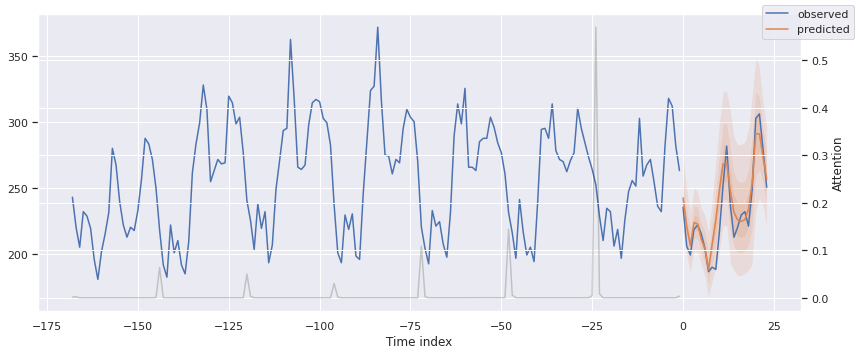

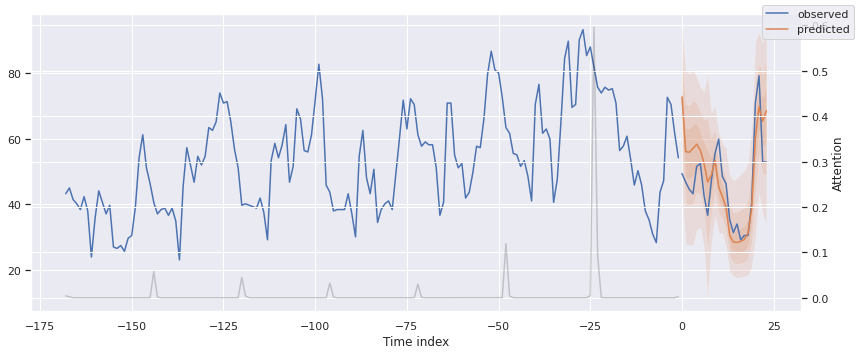

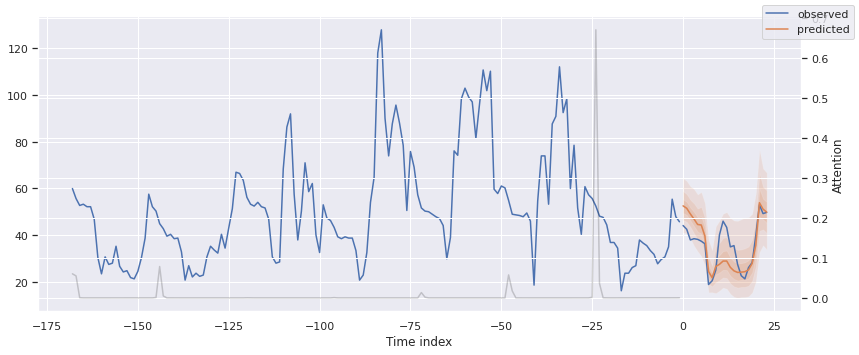

In [21]:
# Visualizing some of the forecasts for other stations

# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

sns.set(rc={'figure.figsize':(12,5)}) # just changing figure size

for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx);

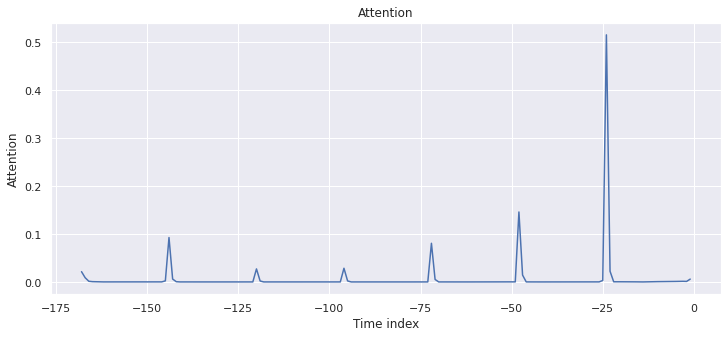

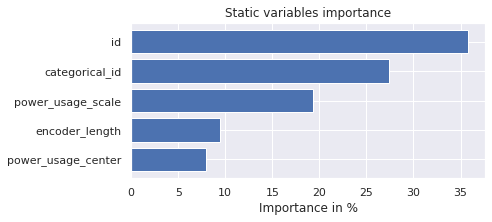

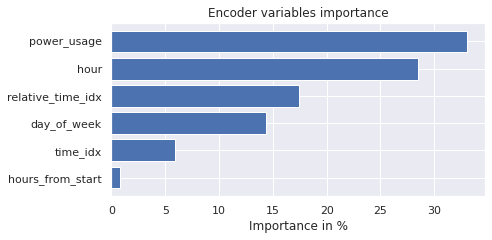

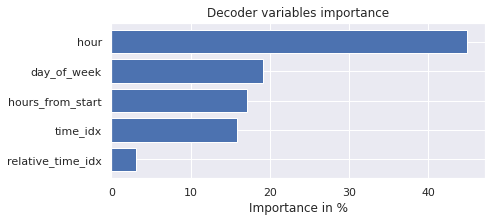

In [22]:
raw_predictions = best_tft.predict(val_dataloader, mode="raw")

interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
_ = best_tft.plot_interpretation(interpretation)

### 1-week Forecast Scenario

Same drill as before, but now predicting for a whole 7 days ahead (max pred. length is now 7 days) of electricity consumption:

In [23]:
max_prediction_length = 7*24 # now the max pred. length is a whole week ahead
max_encoder_length = 7*24 # using the prior week of data.

training_cutoff = electr_df_hourly["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    electr_df_hourly[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx", # variable that contains the time index
    target="power_usage", # target variable to predict
    group_ids=["id"], # Groups used for later normalizing
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1, # at least we predict 1 time index
    max_prediction_length=max_prediction_length,
    static_categoricals=["id","categorical_id"], # they do not change along a same time index
    time_varying_known_categoricals=["day_of_week"], # cats that change for same time idx
    time_varying_known_reals=["time_idx", "hours_from_start", "hour"],
    time_varying_unknown_reals=[
        "power_usage"
    ],
    target_normalizer=GroupNormalizer(
        groups=["id"], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True, # to add the center and scale of the unnormalized timeseries as features
    add_encoder_length=True, # adds decoder length to list of static real variables. 
)

In [24]:
validation = TimeSeriesDataSet.from_dataset(training, electr_df_hourly, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

#### Temporal Fusion Transformer Test (1 week ahead)

In [ ]:
# to solve issue on training (library issue)
import tensorflow as tf 
import tensorboard as tb 
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

We can use Tensorboard panel to visualize how training is going and detect possible issues while executing the model's training:

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
%tensorboard --logdir electr_logs_1week_2

In [ ]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("electr_logs_1week_2")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=30,
    gpus=1,
    weights_summary="top",
    gradient_clip_val=0.1,
    limit_train_batches=300,  # coment in for training, running valiation every 300 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training, # train time series dataset
    learning_rate=0.01,
    hidden_size=160,
    attention_head_size=4, #attention heads
    dropout=0.1,
    hidden_continuous_size=160,
    output_size=7,  # 7 quantiles
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)

print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning:

You have set progress_bar_refresh_rate < 20 on Google Colab. This may crash. Consider using progress_bar_refresh_rate >= 20 in Trainer.

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Number of parameters in network: 2569.3k


In [ ]:
# fit network
trainer.fit(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)

In [ ]:
# Loading best achieved model during training (from checkpoint)
#best_model_path = trainer.checkpoint_callback.best_model_path #pytorch lightning saved the best
best_model_path = "../../trained_models/tft_model_electr_1week.ckpt"
print(best_model_path) # store best model from this path in repo for later use (no waiting time)
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

../../trained_models/tft_model_electr_1week.ckpt


In [ ]:
# Model evaluation (MAE and RMSE)
score = {"MAE" :  best_tft.logging_metrics[1], 
         "RMSE" : best_tft.logging_metrics[2]}
         
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)

tft_MAE_1week = score["MAE"](predictions, actuals)
tft_RMSE_1week = score["RMSE"](predictions, actuals)

print(f"TFT Model MAE (1 week forecast): {tft_MAE_1week:.7f}")
print(f"TFT Model RMSE (1 week forecast): {tft_RMSE_1week:.7f}")

TFT Model MAE (1 week forecast): 50.8037643
TFT Model RMSE (1 week forecast): 398.9714050


We can particularize the predictions to those of the target station MT_320 (the one analyzed in the clasical forecasting models) as follows:

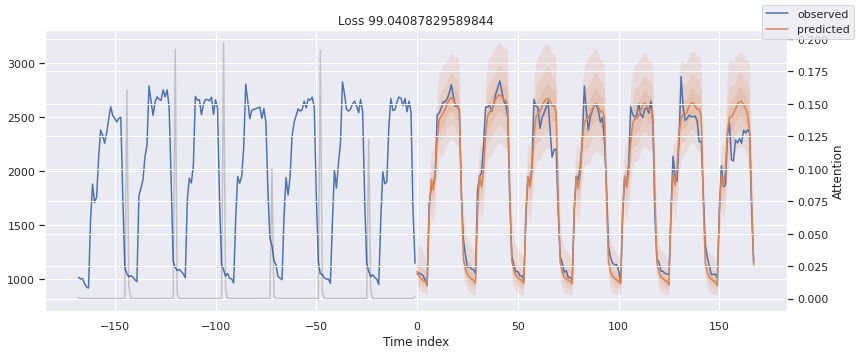

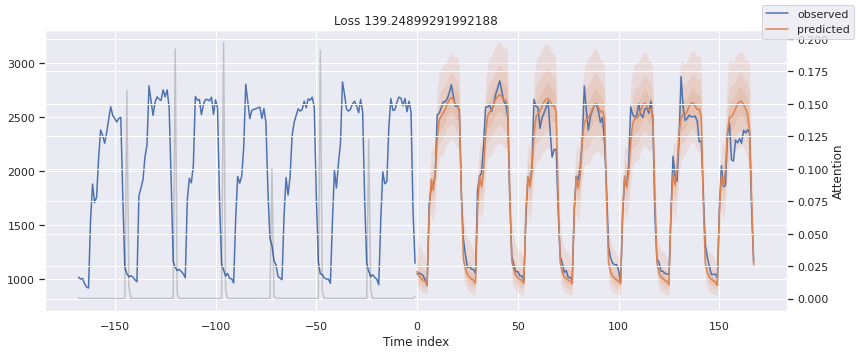

In [ ]:
raw_predictions, x, indx = best_tft.predict(val_dataloader, return_index=True, mode="raw", return_x=True)

sns.set(rc={'figure.figsize':(12,5)}) 

# Index 321 corresponds to station MT_320 analyzed in the previous notebooks
# we plot a validation batch, and the average losses (title)
best_tft.plot_prediction(x, raw_predictions, idx=321, add_loss_to_title=MAE());
best_tft.plot_prediction(x, raw_predictions, idx=321, add_loss_to_title=RMSE());

#### Interpreting the TFT model and 1 week forecast

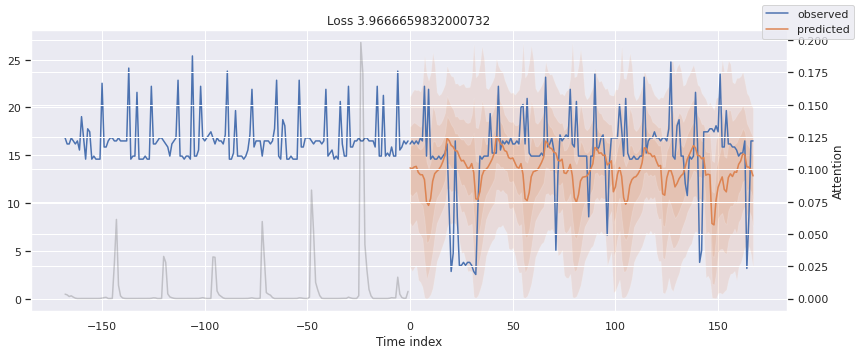

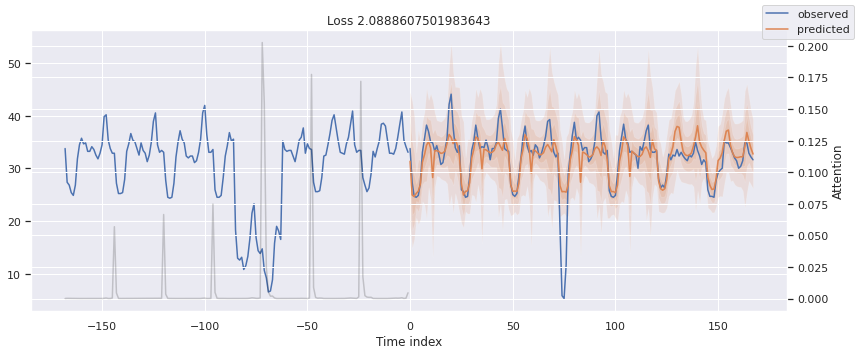

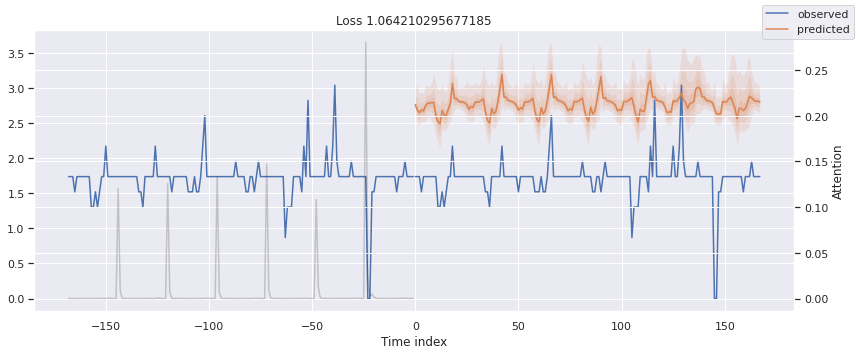

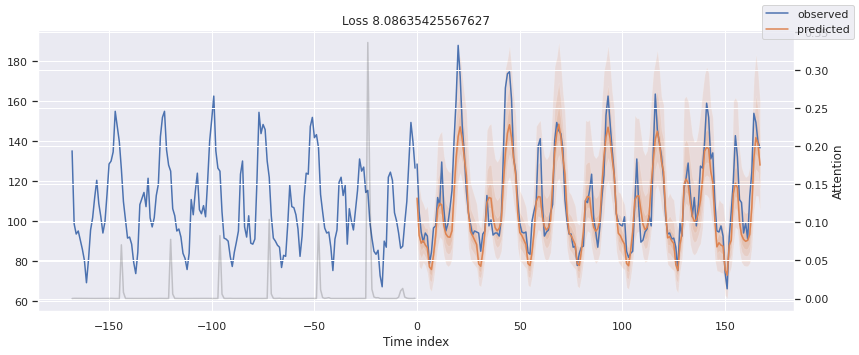

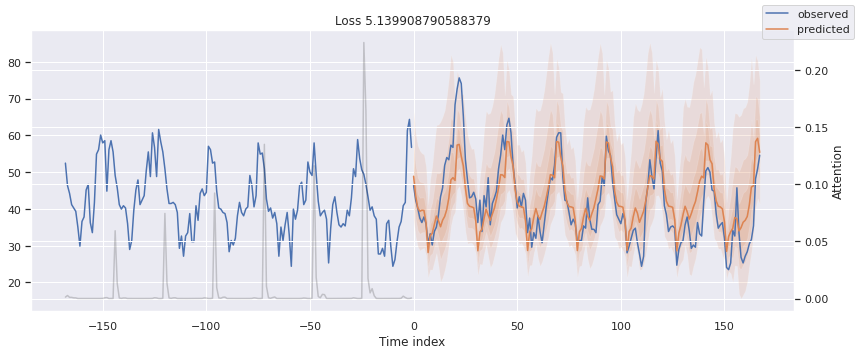

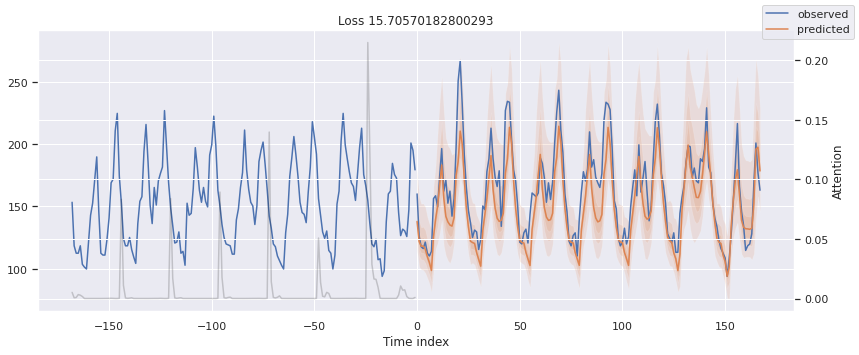

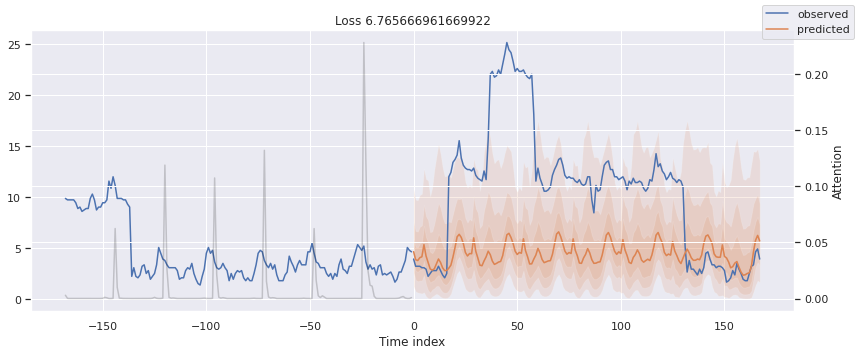

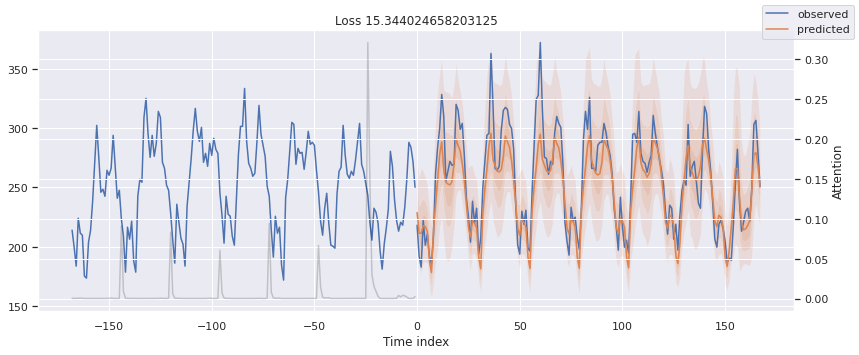

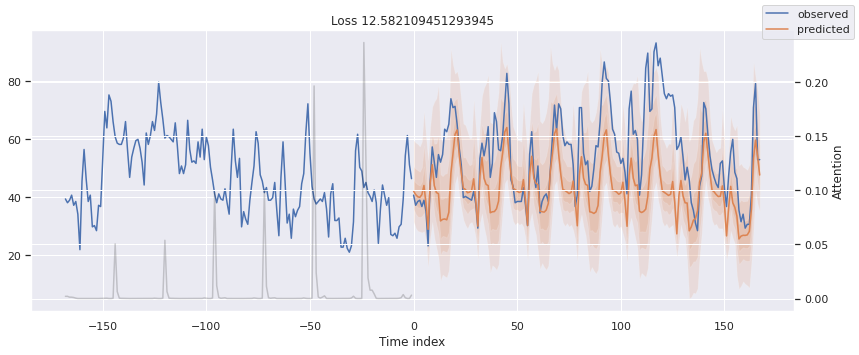

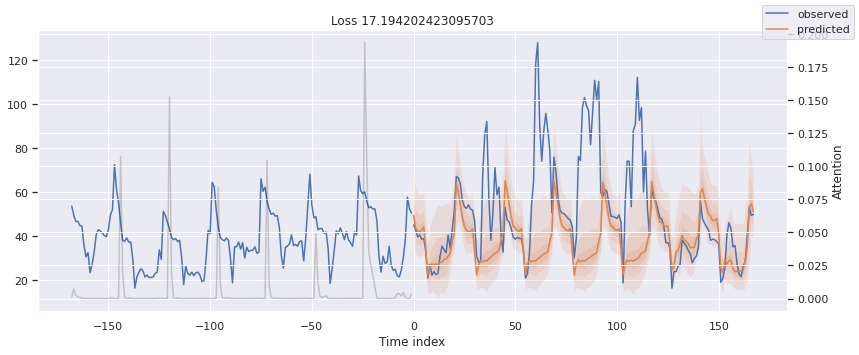

In [ ]:
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

sns.set(rc={'figure.figsize':(12,5)}) # just changing figure size

for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=MAE());

Again, we can also further interpret the attention layer of the model as well as its variables importance:

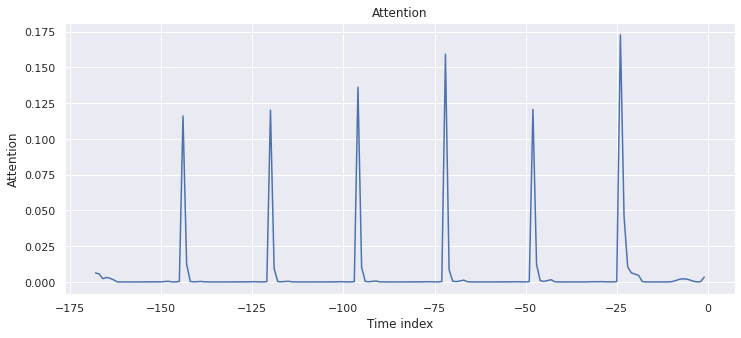

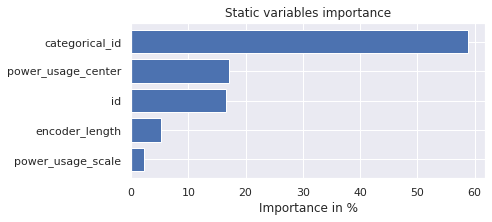

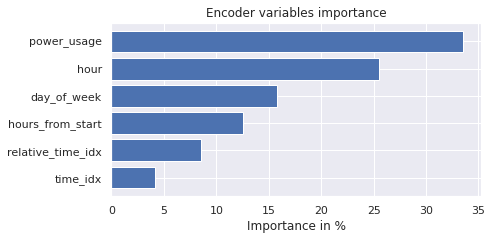

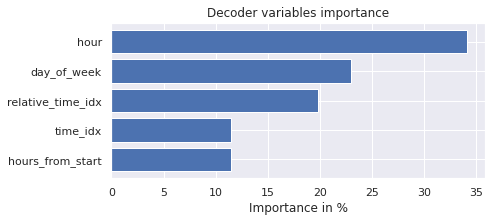

In [ ]:
raw_predictions = best_tft.predict(val_dataloader, mode="raw")

interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
_ = best_tft.plot_interpretation(interpretation)

#### Test with 2 Attention Heads

In [25]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("electr_logs_1week_2")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=30,
    gpus=1,
    weights_summary="top",
    gradient_clip_val=0.1,
    limit_train_batches=300,  # coment in for training, running valiation every 300 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training, # train time series dataset
    learning_rate=0.01,
    hidden_size=160,
    attention_head_size=2, #attention heads
    dropout=0.1,
    hidden_continuous_size=160,
    output_size=7,  # 7 quantiles
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)

print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


Number of parameters in network: 2582.1k


In [ ]:
# fit network
trainer.fit(tft,train_dataloader=train_dataloader,val_dataloaders=val_dataloader)

In [27]:
# Loading best achieved model during training (from checkpoint)
best_model_path = trainer.checkpoint_callback.best_model_path #pytorch lightning saved the best
print(best_model_path) # store best model from this path in repo for later use (no waiting time)
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

electr_logs_1week_2/default/version_1/checkpoints/epoch=20-step=6299.ckpt


In [28]:
# Model evaluation (MAE and RMSE)
score = {"MAE" :  best_tft.logging_metrics[1], 
         "RMSE" : best_tft.logging_metrics[2]}
         
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)

tft_MAE_1week = score["MAE"](predictions, actuals)
tft_RMSE_1week = score["RMSE"](predictions, actuals)

print(f"2-head TFT Model MAE (1 week forecast): {tft_MAE_1week:.7f}")
print(f"2-head TFT Model RMSE (1 week forecast): {tft_RMSE_1week:.7f}")

2-head TFT Model MAE (1 week forecast): 49.5773392
2-head TFT Model RMSE (1 week forecast): 383.0350952


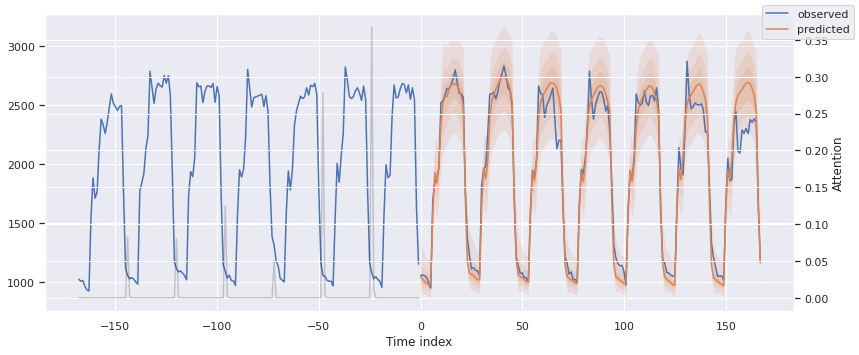

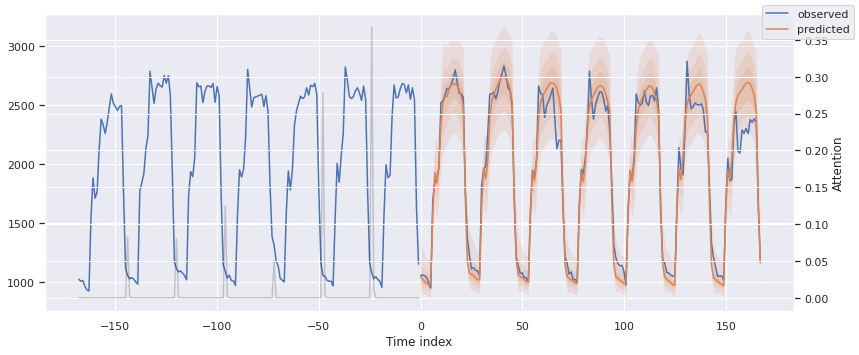

In [29]:
raw_predictions, x, indx = best_tft.predict(val_dataloader, return_index=True, mode="raw", return_x=True)

sns.set(rc={'figure.figsize':(12,5)}) 

# Index 321 corresponds to station MT_320 analyzed in the previous notebooks
best_tft.plot_prediction(x, raw_predictions, idx=321);
best_tft.plot_prediction(x, raw_predictions, idx=321);

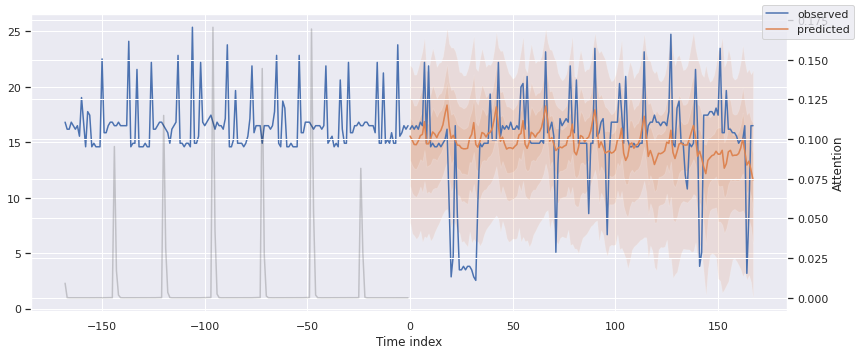

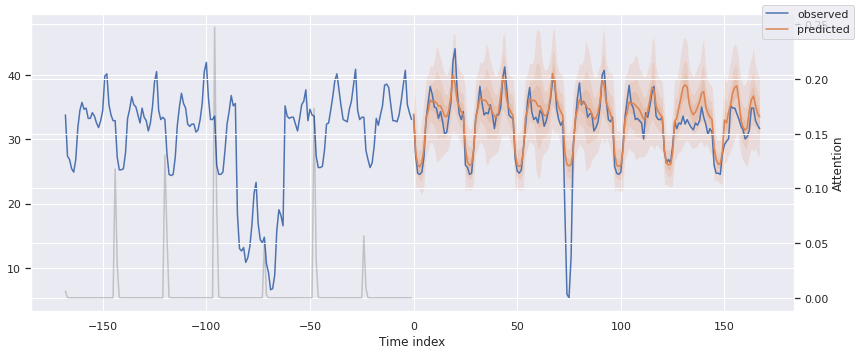

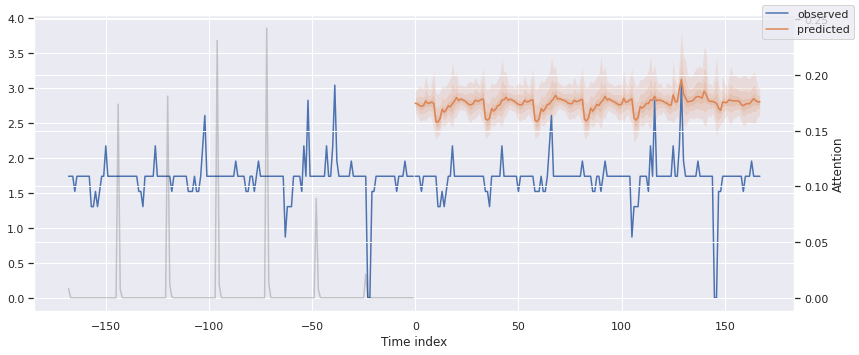

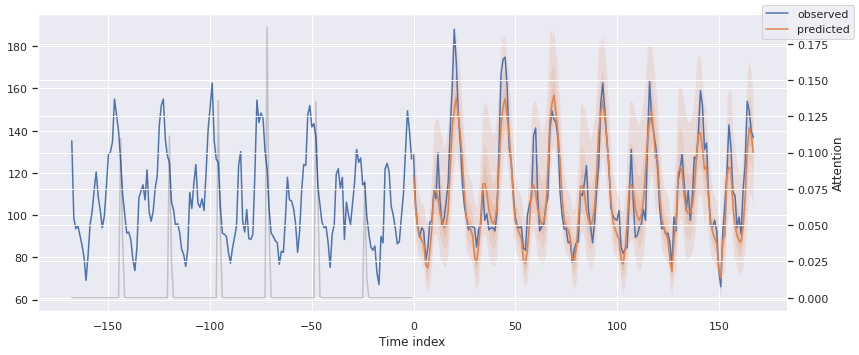

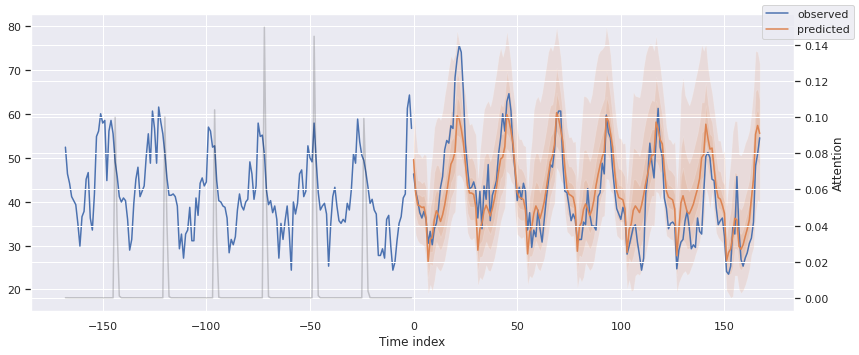

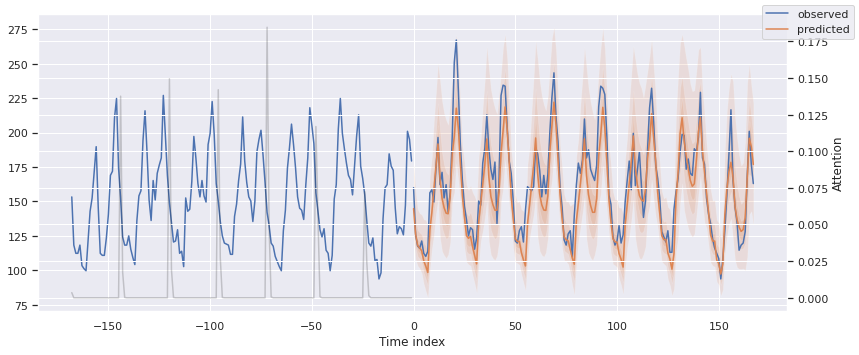

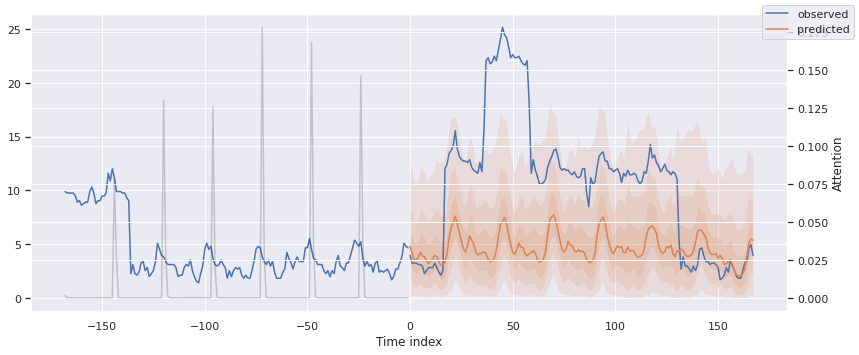

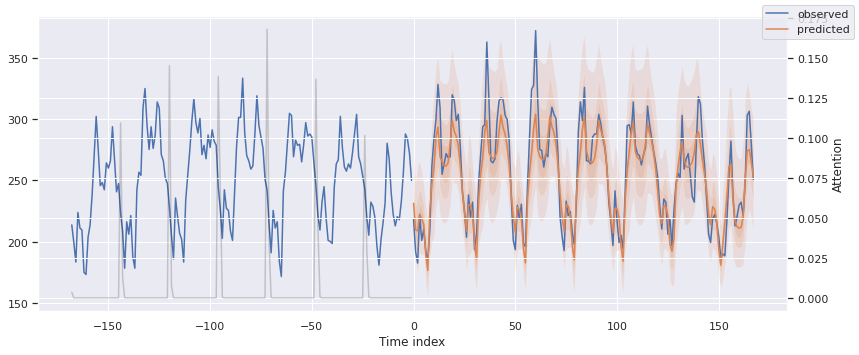

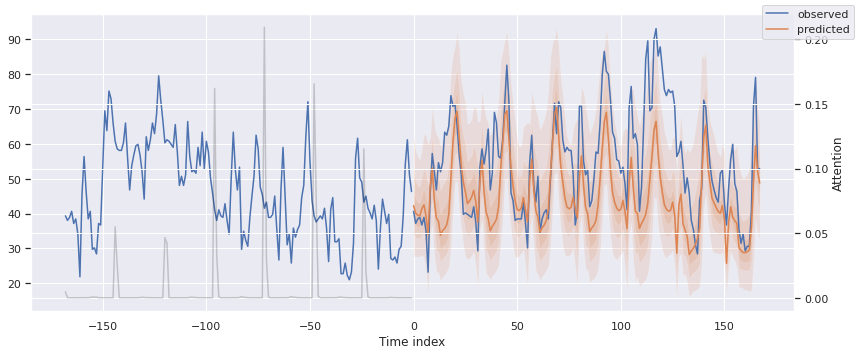

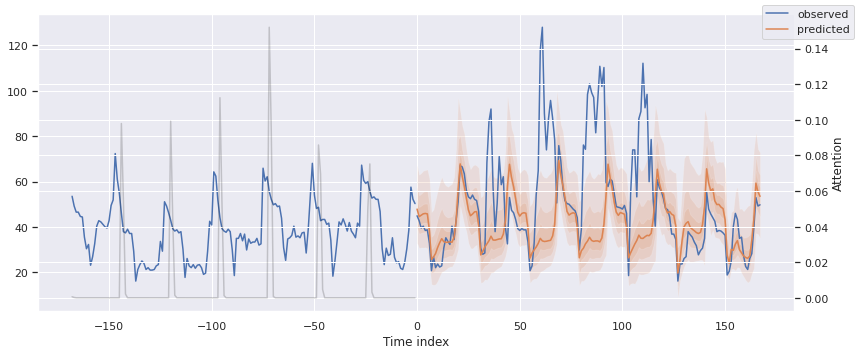

In [30]:
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

sns.set(rc={'figure.figsize':(12,5)}) # just changing figure size

for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx);

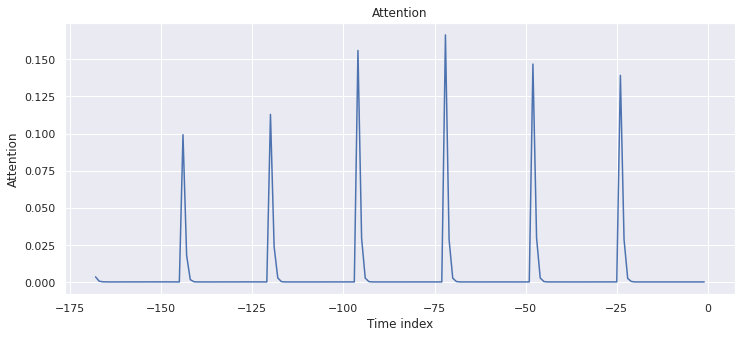

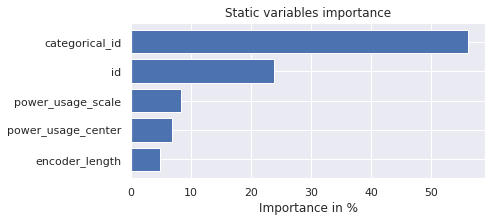

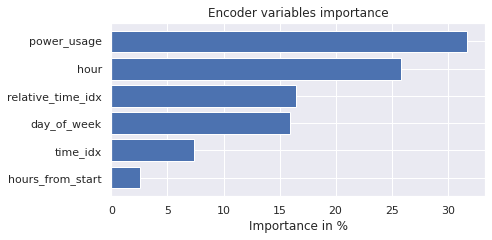

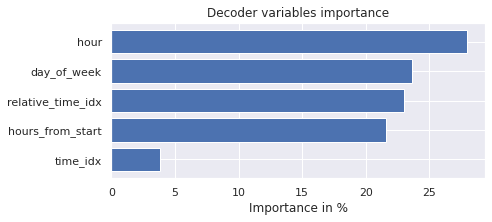

In [31]:
raw_predictions = best_tft.predict(val_dataloader, mode="raw")

interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
_ = best_tft.plot_interpretation(interpretation)